In [1]:
import itertools

import numpy as np
import seaborn as sns
import pandas as pd
import functools
from functools import lru_cache

from paderbox.visualization import plot, context_manager
from padercontrib.database.keys import *
from padercontrib.database.iterator import AudioReader
from paderbox.transform import stft
from paderbox.array import interval
from padercontrib.visualization.database_to_html import display_database_html
from padercontrib.database.chime5.database import activity_time_to_frequency

from padercontrib.database.fearless import Fearless

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from functools import partial
import itertools

import padercontrib.database.keys as K
from padercontrib.database.sms_wsj import SmsWsj
from padercontrib.visualization.database_to_html import display_database_html
from paderbox.visualization import context_manager
from padercontrib.database.iterator import AudioReader
from paderbox.notebook import play, plot, stft, axes_context

import pandas as pd
import numpy as np

In [3]:
from paderbox.notebook import *
import paderbox as pb
import padercontrib as pc
import padertorch as pt
from padertorch.data.segment import get_segment_boundaries
from padertorch.data.utils import collate_fn

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import random

In [13]:
from paderbox.notebook import *
import paderbox as pb
import padercontrib as pc
from padertorch.data.segment import get_segment_boundaries
from padertorch.data.utils import collate_fn
from padercontrib.database.chime5.database import activity_time_to_frequency

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_data_preparation(data, dataset, batch_size=10, shuffle=False):
    
    """Accessing audio stream from train stream"""
    data = data
    dataset = dataset
    mfcc = pb.transform.mfcc

    """Adding a activity dictionary to existing dataset"""
    def activity(dataset):
        get_activity = data.get_activity(dataset)
        dataset['activity'] = get_activity
        dataset['audio_path'] = dataset['audio_path']['observation']
        return dataset


    """Segment the audio in dataset"""
    def segmentation(dataset, chunk_size=32000):
        segment_audio = []
        boundaries = get_segment_boundaries(dataset['num_samples'], chunk_size, anchor='random')
        for start,stop in boundaries:
            audio_chunk = dataset.copy()
            audio_chunk.update(audio_start = start)
            audio_chunk.update(audio_stop = stop)
            audio_chunk.update(label = (activity_time_to_frequency(dataset['activity'][start:stop], 
                                            stft_window_length=400, 
                                            stft_shift=160, 
                                            stft_fading=None)))
            segment_audio.append(audio_chunk)
        return segment_audio

    """Read the audio file"""
    def mfcc_feature(dataset):
        audio = dataset['audio_path']
        start = dataset['audio_start']
        stop = dataset['audio_stop']
        feature = mfcc(pb.io.load_audio(audio, start=start, stop=stop), stft_shift=160)
        dataset['features'] = feature.astype(np.float32)
        dataset['label'] = np.asarray(dataset['label']).astype(np.float32)
        return dataset

    """Keeping only needed dicitionary"""
    def new_dataset(dataset):
        dic = dict()
        dic['example_id'] = dataset['example_id']
        dic['features'] = np.expand_dims(dataset['features'], axis=0)
        dic['features_shape'] = dic['features'].shape
        dic['label'] = np.asarray(dataset['label']).astype(np.float32)
        return dic

    """Stacking all the batch of features and class label to nparray"""
    def conv_list_nparray(dataset):
        dataset['features'] = np.stack(dataset['features'])
        dataset['label'] = np.vstack(dataset['label'])
        return dataset


    """ Mapping, shuffling, Prefetch, unbatch, batch_map, batch and collate_fn"""
    dataset = dataset.map(activity)
    dataset = dataset.map(segmentation)
    if shuffle:
        dataset = dataset.shuffle()
    dataset = dataset.prefetch(num_workers=1, buffer_size=8).unbatch()
    dataset = dataset.map(mfcc_feature)
    dataset = dataset.map(new_dataset)
    dataset = dataset.batch(batch_size).map(collate_fn)
    dataset = dataset.map(conv_list_nparray)
    
    return dataset

In [14]:
def get_data_preparation_p(data, dataset, batch_size=10, shuffle=False):
    
    """Accessing audio stream from train stream"""
    data = data
    dataset = dataset
    mfcc = pb.transform.mfcc

    """Adding a activity dictionary to existing dataset"""
    def activity(dataset):
        get_activity = data.get_activity(dataset)
        dataset['activity'] = get_activity
        dataset['audio_path'] = dataset['audio_path']['observation']
        return dataset
    
    """zero extension"""
    def zero_extension(dataset):
        x = np.arange(dataset['num_samples'])
        desired_length = 32000
        num_splits = np.ceil(x.shape[0]/desired_length)
        padding = int(num_splits*desired_length - x.shape[0])
        x_pad = np.pad(x, (0,padding), 'constant', constant_values=0)
        dataset['padded_num_samples'] = len(x_pad)
        dataset['activity'].shape = (len(x_pad),)
        return dataset
    
    """Segment the audio in dataset"""
    def segmentation(dataset, chunk_size=32000):
        segment_audio = []
        boundaries = get_segment_boundaries(dataset['padded_num_samples'], chunk_size)
        for start,stop in boundaries:
            audio_chunk = dataset.copy()
            audio_chunk.update(audio_start = start)
            audio_chunk.update(audio_stop = stop)
            audio_chunk.update(label = (activity_time_to_frequency(dataset['activity'][start:stop], 
                                            stft_window_length=400, 
                                            stft_shift=160, 
                                            stft_fading=None)))
            segment_audio.append(audio_chunk)
        return segment_audio

    """Read the audio file"""
    
    def mfcc_feature(dataset):
        start = dataset['audio_start']
        stop = dataset['audio_stop']
        if dataset['num_samples'] % 32000 != 0:
            audio = pb.io.load_audio(dataset['audio_path']).copy()
            y = np.arange(len(audio))
            desired_length = 32000
            num_splits = np.ceil(y.shape[0]/desired_length)
            padding = int(num_splits*desired_length - y.shape[0])
            y_pad = len(np.pad(y, (0,padding), 'constant', constant_values=0))
            audio.resize(y_pad)
            feature = mfcc(audio[start:stop], stft_shift=160)
        else:
            audio = dataset['audio_path']
            feature = mfcc(pb.io.load_audio(audio, start=start, stop=stop), stft_shift=160)
        dataset['features'] = feature.astype(np.float32)
        dataset['label'] = np.asarray(dataset['label']).astype(np.float32)
        return dataset

    """Keeping only needed dicitionary"""
    def new_dataset(dataset):
        dic = dict()
        dic['example_id'] = dataset['example_id']
        dic['features'] = np.expand_dims(dataset['features'], axis=0)
        dic['features_shape'] = dic['features'].shape
        dic['label'] = dataset['label']
        return dic

    """Stacking all the batch of features and class label to nparray"""
    def conv_list_nparray(dataset):
        dataset['features'] = np.stack(dataset['features'])
        dataset['label'] = np.vstack(dataset['label'])
        return dataset


    """ Mapping, shuffling, Prefetch, unbatch, batch_map, batch and collate_fn"""
    dataset = dataset.map(activity)
    dataset = dataset.map(zero_extension)  
    dataset = dataset.map(segmentation)
    
#    if shuffle:
#        dataset = dataset.shuffle()
    dataset = dataset.prefetch(num_workers=1, buffer_size=8).unbatch()
    dataset = dataset.map(mfcc_feature)
    dataset = dataset.map(new_dataset)
    dataset = dataset.batch(batch_size).map(collate_fn)
    dataset = dataset.map(conv_list_nparray)
    
    return dataset

In [15]:
data = pc.database.fearless.Fearless()
dev_stream = data.get_dataset('Dev_stream')
dev_data = get_data_preparation(data, dev_stream)

In [8]:
for i in dev_data:
    
    print(i)

{'example_id': ['FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001'], 'features': array([[[[-64.81184   ,   1.6925446 ,  -2.5271313 , ...,  -0.3927653 ,
            0.48215806,  -5.0031896 ],
         [-64.80851   ,   1.7620299 ,  -3.8727167 , ...,   0.4718145 ,
           -1.8980931 ,  -1.1438315 ],
         [-65.01371   ,   1.4352287 ,  -3.1439385 , ...,  -0.40770018,
           -4.0386024 ,  -4.5918984 ],
         ...,
         [-65.050804  ,   2.1017764 ,  -2.9222548 , ...,  -6.606334  ,
           -3.4080918 , -10.585111  ],
         [-65.00222   ,   1.7242986 ,  -2.645731  , ...,  -9.790786  ,
           -1.7029338 ,  -9.337602  ],
         [-65.160545  ,   1.3832891 ,  -3.5412197 , ...,  -5.0870967 ,
           -6.573004  ,  -9.233831  ]]],


       [[[-65.127815  ,   1.6920813 ,  -4.1772566 , ...,  -6.6424956 ,
            1.4348564 ,  -7.181585  ],
         [-65.0604    ,

{'example_id': ['FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001'], 'features': array([[[[-6.5153328e+01,  1.9158496e+00, -3.9051833e+00, ...,
          -2.8744864e+00, -1.3804412e+00, -7.4365044e+00],
         [-6.4990250e+01,  1.5812166e+00, -3.6905222e+00, ...,
          -5.1465068e+00,  3.0481350e+00, -1.1645345e+01],
         [-6.4667915e+01,  9.0804881e-01, -4.6899161e+00, ...,
          -7.2381175e-01,  2.5452430e+00, -8.3682775e+00],
         ...,
         [-6.4986916e+01,  1.4464052e+00, -4.6477661e+00, ...,
          -6.5564513e+00, -2.6140630e-01, -9.5554371e+00],
         [-6.4723991e+01,  1.5535263e+00, -4.0895224e+00, ...,
          -7.4661932e+00, -2.3023722e+00, -8.6717253e+00],
         [-6.4830299e+01,  2.3462143e+00, -3.6420131e+00, ...,
          -5.6993947e+00, -4.0798131e-01, -7.9489093e+00]]],


       [[[-6.4919670e+01,  2.5351822e+00, -3.9126451e+00, ...

{'example_id': ['FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001'], 'features': array([[[[-64.69711   ,   2.1725998 ,  -2.8482006 , ...,  -4.9600506 ,
           -3.5918443 , -10.496797  ],
         [-64.96636   ,   2.559144  ,  -3.9360309 , ...,  -7.8933387 ,
           -6.5504255 ,  -7.8133583 ],
         [-64.618095  ,   1.5593143 ,  -3.082352  , ..., -12.077629  ,
           -8.285083  ,  -4.983749  ],
         ...,
         [-65.38054   ,   1.6185868 ,  -4.74628   , ...,  -5.2072153 ,
           -3.8526087 ,  -8.826211  ],
         [-64.652     ,   0.51326597,  -4.894577  , ...,  -2.5202703 ,
           -1.4236892 ,  -2.886587  ],
         [-64.92822   ,   1.2846336 ,  -4.834137  , ...,   2.071951  ,
           -3.0005925 ,   1.2355285 ]]],


       [[[-65.0737    ,   0.9278542 ,  -4.1502757 , ...,  -0.90357167,
           -2.4588535 ,  -6.156062  ],
         [-65.026474  ,

{'example_id': ['FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001'], 'features': array([[[[-64.41831   ,   0.8430995 ,  -2.2564807 , ...,  -0.8207751 ,
           -2.564428  ,  -5.8744116 ],
         [-64.58595   ,   0.9657639 ,  -3.7375915 , ...,  -2.9956014 ,
            0.7425572 ,  -3.2774951 ],
         [-64.87426   ,   1.2641399 ,  -4.2914715 , ...,  -2.9583564 ,
            2.8573287 ,  -3.3692405 ],
         ...,
         [-64.69643   ,   1.8820938 ,  -4.6787505 , ...,  -1.9863013 ,
            5.0892544 , -11.527369  ],
         [-64.56957   ,   1.8649817 ,  -4.8129663 , ...,  -4.467686  ,
            3.5732558 ,  -6.921118  ],
         [-64.56144   ,   1.6458164 ,  -5.185578  , ...,  -4.25793   ,
            0.2852434 ,  -5.024908  ]]],


       [[[-64.641075  ,   1.6896936 ,  -4.244017  , ...,  -3.8311937 ,
           -1.5534608 ,   1.9219363 ],
         [-64.61363   ,

{'example_id': ['FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001'], 'features': array([[[[-65.17697   ,   2.7934632 ,  -3.9726565 , ..., -10.684956  ,
           -2.0611484 ,  -9.947133  ],
         [-64.64358   ,   1.3422215 ,  -4.585742  , ..., -13.836517  ,
           -3.9470878 ,  -5.6907716 ],
         [-64.65167   ,   1.3063484 ,  -2.626944  , ...,  -5.749647  ,
           -5.5061073 ,  -6.5547066 ],
         ...,
         [-65.137596  ,   0.9383044 ,  -4.1654987 , ...,  -2.7377176 ,
           -0.8078604 , -10.263999  ],
         [-65.085976  ,   2.232377  ,  -5.8768163 , ...,  -2.6848469 ,
            0.8537446 ,  -7.1072044 ],
         [-64.620834  ,   1.3358347 ,  -3.9019043 , ...,  -3.5645516 ,
           -3.9299316 ,  -9.684959  ]]],


       [[[-64.66388   ,   1.0969365 ,  -4.0041833 , ...,  -3.4192007 ,
            1.7745435 , -10.626701  ],
         [-64.83488   ,

{'example_id': ['FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001', 'FS02_dev_001'], 'features': array([[[[-6.4604340e+01,  1.9032555e+00, -7.3019481e-01, ...,
          -7.4696984e+00, -6.0458503e+00, -5.7707520e+00],
         [-6.4416069e+01,  2.4287009e+00, -3.8889198e+00, ...,
          -8.4410381e+00, -1.2622492e+00, -8.0422487e+00],
         [-6.4174080e+01,  1.6504390e+00, -2.7307618e+00, ...,
          -1.2127545e+01,  1.9642793e-01, -7.8921447e+00],
         ...,
         [-6.5034271e+01,  1.7401909e+00, -3.1628332e+00, ...,
          -3.8964565e+00, -1.9919679e+00, -2.5563102e+00],
         [-6.4890091e+01,  5.3130770e-01, -3.2911620e+00, ...,
          -4.8828154e+00,  4.5267221e-01, -6.8082547e+00],
         [-6.5066643e+01,  1.0706670e+00, -3.1958985e+00, ...,
           2.1624637e-01, -7.7109331e-01, -5.6695080e+00]]],


       [[[-6.4886238e+01,  1.5937488e+00, -3.8075256e+00, ...

{'example_id': ['FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002'], 'features': array([[[[-6.04430809e+01,  2.94038796e+00, -2.56552105e+01, ...,
          -3.14523935e+00, -1.36312568e+00, -1.39144535e+01],
         [-6.08985443e+01,  4.22010136e+00, -2.37259560e+01, ...,
          -2.32100010e-01, -6.04992676e+00, -7.86181736e+00],
         [-6.28219986e+01,  8.04364586e+00, -2.10903873e+01, ...,
          -9.69297218e+00, -4.75271940e+00,  2.06303859e+00],
         ...,
         [-6.39123421e+01,  1.70319355e+00, -7.97003794e+00, ...,
          -1.39810553e+01, -2.30668259e+00,  3.87090594e-01],
         [-5.99503174e+01,  8.12378600e-02, -1.66338310e+01, ...,
          -1.08412533e+01,  8.09366226e+00,  2.25772202e-01],
         [-6.20167313e+01,  1.35919619e+00, -1.82761669e+01, ...,
           4.19882011e+00,  6.46987200e+00, -1.16039252e+00]]],


       [[[-6.27313156e+01

{'example_id': ['FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002'], 'features': array([[[[-6.69973831e+01,  3.35594106e+00, -4.90429068e+00, ...,
          -7.56690741e-01, -6.63231421e+00, -9.58638477e+00],
         [-6.69263153e+01,  3.56508827e+00, -6.21451664e+00, ...,
          -3.08605939e-01, -2.62798309e+00, -1.18477373e+01],
         [-6.70650940e+01,  2.84221077e+00, -5.04404449e+00, ...,
          -7.79782653e-01, -1.53426445e+00, -9.64320469e+00],
         ...,
         [-6.69992065e+01,  7.44664550e-01, -6.04705095e+00, ...,
           3.91241014e-01, -2.52642441e+00, -1.01954660e+01],
         [-6.72740479e+01,  2.03441238e+00, -5.05265903e+00, ...,
          -7.10295820e+00, -1.35539830e+00, -1.26537399e+01],
         [-6.72004089e+01,  3.14125466e+00, -4.95132542e+00, ...,
          -6.90996122e+00,  2.34421039e+00, -9.12802124e+00]]],


       [[[-6.71780472e+01

{'example_id': ['FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002'], 'features': array([[[[-66.36837   ,   3.3635874 ,  -3.9168296 , ..., -10.479007  ,
           -2.7290688 ,  -9.330244  ],
         [-66.973465  ,   4.4005365 ,  -5.737014  , ...,  -4.920426  ,
           -4.4691877 ,  -9.878454  ],
         [-66.4224    ,   2.326883  ,  -6.077524  , ...,   0.48920175,
           -7.759268  , -10.913215  ],
         ...,
         [-66.558784  ,   1.3353971 ,  -3.8585486 , ...,  -3.1454573 ,
            1.4824432 , -13.229286  ],
         [-66.456924  ,   2.792056  ,  -6.0228577 , ...,  -4.9205494 ,
            2.4731996 , -16.661263  ],
         [-67.21477   ,   3.351868  ,  -4.9534793 , ...,   0.73996955,
           -4.837611  , -11.844235  ]]],


       [[[-66.52298   ,   3.1741662 ,  -3.361418  , ...,  -9.958084  ,
           -7.3579116 ,  -9.83043   ],
         [-66.766754  ,

{'example_id': ['FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002'], 'features': array([[[[-5.94004822e+01, -3.83456826e+00, -1.46525860e+01, ...,
          -1.34525192e+00, -1.77315369e+01, -5.66319370e+00],
         [-5.86420021e+01, -5.16164351e+00, -1.42106667e+01, ...,
           8.13868225e-01, -1.67887993e+01, -2.12464952e+00],
         [-5.83991661e+01, -5.49682379e+00, -1.73900204e+01, ...,
          -1.00342798e+01, -3.59022999e+00, -5.96384144e+00],
         ...,
         [-6.11077156e+01, -3.24972153e+00, -2.12878895e+01, ...,
           5.31256437e+00, -6.61925220e+00, -8.98813534e+00],
         [-6.11688042e+01, -3.35632825e+00, -1.56159649e+01, ...,
           7.77550316e+00, -7.37580156e+00, -1.30329342e+01],
         [-6.10177650e+01, -2.24654937e+00, -1.55743036e+01, ...,
          -2.49743962e+00,  1.20621398e-01, -1.15136042e+01]]],


       [[[-6.05985870e+01

{'example_id': ['FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002', 'FS02_dev_002'], 'features': array([[[[-66.53006   ,   5.375629  ,  -4.5683475 , ...,  -8.981815  ,
           -4.4737267 ,  -9.522289  ],
         [-66.48291   ,   4.502504  ,  -3.6266904 , ...,  -8.419231  ,
           -3.93675   , -11.2079    ],
         [-66.404236  ,   4.956604  ,  -2.9768062 , ...,  -8.226799  ,
           -7.300878  , -11.116646  ],
         ...,
         [-62.48822   ,   6.4120936 , -16.118721  , ..., -15.967213  ,
            4.15118   , -12.7085    ],
         [-61.537613  ,   5.178096  , -17.204428  , ..., -15.197575  ,
            4.838875  ,  -5.4543853 ],
         [-61.921185  ,   5.016951  , -15.73184   , ..., -10.017252  ,
            1.5934445 ,  -3.0079777 ]]],


       [[[-66.71257   ,   5.031174  ,  -4.3861613 , ...,  -7.5610647 ,
           -7.258421  ,  -8.75652   ],
         [-66.70282   ,

{'example_id': ['FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003'], 'features': array([[[[-6.57834625e+01,  2.59476042e+00, -1.18213606e+00, ...,
          -6.91568184e+00,  7.55761528e+00, -6.13100052e+00],
         [-6.56795120e+01,  2.27553868e+00, -2.17423058e+00, ...,
          -6.68564892e+00,  3.64223957e+00,  1.12145746e+00],
         [-6.55108643e+01,  1.08845937e+00, -1.20763850e+00, ...,
          -6.47472477e+00,  2.91649771e+00,  6.14265680e+00],
         ...,
         [-6.51895981e+01,  6.15680838e+00, -2.11492395e+00, ...,
          -2.39697766e+00, -7.07110214e+00,  1.57060564e+00],
         [-6.50465546e+01,  6.27174568e+00, -1.17132533e+00, ...,
          -5.34208345e+00, -6.14977293e-02, -9.65245485e-01],
         [-6.48804626e+01,  4.80707169e+00, -4.26650238e+00, ...,
          -6.62531757e+00,  4.02652311e+00, -1.16813049e+01]]],


       [[[-6.53944626e+01

{'example_id': ['FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003'], 'features': array([[[[-6.6617172e+01, -2.7301686e+00, -5.1472678e+00, ...,
          -8.1387014e+00, -4.5055561e+00, -2.8971667e+00],
         [-6.4032135e+01, -6.0116634e-02, -1.0074350e+01, ...,
          -6.9674478e+00, -1.9753721e+00, -2.8653200e+00],
         [-6.3655788e+01,  1.2596970e+00, -1.1724163e+01, ...,
          -4.5587158e+00,  1.6223311e+00, -9.8406391e+00],
         ...,
         [-6.6023338e+01,  1.6321726e+00, -2.2179010e+00, ...,
          -2.2617447e+00, -1.1856744e+00, -9.2571611e+00],
         [-6.5989799e+01,  2.0013094e+00, -1.8593854e+00, ...,
          -1.0994396e+01, -1.2512468e+00, -1.4786235e+01],
         [-6.6226273e+01,  2.2314124e+00, -3.7743611e+00, ...,
          -1.2348313e+01, -8.6651669e+00, -1.0540831e+01]]],


       [[[-6.5770119e+01,  3.3286757e+00, -6.3718748e+00, ...

{'example_id': ['FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003'], 'features': array([[[[-5.50005035e+01,  4.05551815e+00, -3.49997826e+01, ...,
          -1.61096275e-01, -1.04013386e+01, -8.90925121e+00],
         [-4.71380539e+01,  1.01851928e+00, -4.97013855e+01, ...,
           2.43708038e+00, -1.17559462e+01, -1.13672409e+01],
         [-4.67038841e+01,  5.19010246e-01, -4.84291115e+01, ...,
          -7.19057417e+00, -1.12971764e+01, -1.42350445e+01],
         ...,
         [-6.56237183e+01,  8.31277311e-01, -9.05100632e+00, ...,
          -4.45970583e+00,  8.74797821e+00, -1.11742001e+01],
         [-6.49707260e+01, -2.44168729e-01, -1.24112549e+01, ...,
          -3.83569646e+00,  3.17088991e-01, -6.82861090e+00],
         [-6.54486618e+01, -5.54919600e-01, -1.07347355e+01, ...,
          -4.93095446e+00, -4.28659439e+00, -7.72532988e+00]]],


       [[[-6.53437576e+01

{'example_id': ['FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003'], 'features': array([[[[-5.4180660e+01, -1.3261377e+01, -1.9653906e+01, ...,
          -6.9076114e+00,  1.5926555e+01,  8.0365391e+00],
         [-5.1065983e+01, -1.4821717e+01, -3.1189747e+01, ...,
          -1.8246800e+00,  3.8436265e+00,  6.5731277e+00],
         [-5.1552391e+01, -1.2944075e+01, -2.9849258e+01, ...,
          -8.7247648e+00, -3.3832433e+00, -3.8988848e+00],
         ...,
         [-6.0455158e+01, -1.6892945e+00, -1.9888329e+01, ...,
          -2.1551668e+01, -2.2991240e-01, -1.9225388e+00],
         [-5.7530117e+01, -3.0587871e+00, -2.7090437e+01, ...,
           6.6294646e+00,  3.1346050e-01, -1.2763073e+01],
         [-5.4417171e+01, -6.0600462e+00, -3.3971962e+01, ...,
           1.2358271e+01, -8.9646015e+00,  1.1052171e+00]]],


       [[[-5.2825024e+01, -9.5554743e+00, -3.6300831e+01, ...

{'example_id': ['FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003', 'FS02_dev_003'], 'features': array([[[[-66.63392   ,   0.360375  ,  -4.527782  , ..., -11.228984  ,
           -6.7635074 ,  -7.962194  ],
         [-65.265175  ,   1.7171949 ,  -7.7289014 , ..., -10.066656  ,
           -7.0220814 , -12.365711  ],
         [-66.50447   ,   3.0541265 ,  -2.885409  , ..., -15.697471  ,
           -2.220123  ,  -5.9897537 ],
         ...,
         [-65.10534   ,   1.840955  ,  -3.8524113 , ...,  -2.1905375 ,
            2.0061586 , -12.350601  ],
         [-64.16024   ,   2.0405846 ,  -4.301102  , ...,  -0.9908674 ,
           -0.10167291,  -9.736027  ],
         [-64.38106   ,   2.022191  ,  -3.8736014 , ...,  -2.156303  ,
            2.3164802 ,  -1.9417797 ]]],


       [[[-64.777985  ,   2.6703913 ,  -4.346115  , ...,  -9.241082  ,
            9.326371  ,  -2.0652566 ],
         [-65.697044  ,

{'example_id': ['FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004'], 'features': array([[[[-53.673645  ,   8.927946  ,  -4.007202  , ...,   0.5338187 ,
            7.159665  ,   3.9869041 ],
         [-53.603447  ,   8.773917  ,  -4.434531  , ...,   4.2009473 ,
            5.827204  ,   5.2772923 ],
         [-53.35814   ,   8.84673   ,  -5.9317203 , ...,   5.3880153 ,
            1.8727437 ,   2.869674  ],
         ...,
         [-52.515457  ,   6.281811  ,  -7.353884  , ...,  10.383516  ,
            9.241008  ,   4.621226  ],
         [-53.066864  ,   7.193116  ,  -8.186049  , ...,  13.988446  ,
           12.971249  ,   1.9457264 ],
         [-52.99464   ,   6.5421247 ,  -8.940607  , ...,   5.9226956 ,
           13.4132    ,   4.3593235 ]]],


       [[[-53.336372  ,   7.1516967 ,  -6.472311  , ...,  10.24674   ,
           12.981515  ,   0.16700052],
         [-52.719414  ,

{'example_id': ['FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004'], 'features': array([[[[-5.4412601e+01,  8.6934633e+00, -6.2820249e+00, ...,
           6.7970757e+00,  1.3863008e+01,  4.5376019e+00],
         [-5.4440453e+01,  7.9956412e+00, -3.4966912e+00, ...,
           9.9948874e+00,  9.8320541e+00,  7.3274894e+00],
         [-5.4512749e+01,  8.5746441e+00, -4.6024528e+00, ...,
           1.0395716e+01,  1.2323069e+01,  5.5675025e+00],
         ...,
         [-5.1309658e+01,  4.7293015e+00, -8.4724388e+00, ...,
          -2.7206755e+00,  4.8946257e+00,  7.4029222e+00],
         [-5.2100418e+01,  5.5838804e+00, -4.4693856e+00, ...,
           9.9358873e+00,  4.8488173e+00,  2.2177947e+00],
         [-5.2218109e+01,  5.9987555e+00, -7.7573786e+00, ...,
           1.0358552e+01,  7.9843154e+00,  1.0138757e+00]]],


       [[[-5.2568237e+01,  5.9953680e+00, -8.1857767e+00, ...

{'example_id': ['FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004'], 'features': array([[[[-54.12372   ,   7.7845116 ,  -3.7422535 , ...,   9.439425  ,
            9.016988  ,   2.1264575 ],
         [-54.22643   ,   8.359714  ,  -4.749766  , ...,  11.565157  ,
            5.4856067 ,   6.846715  ],
         [-53.802235  ,   8.286424  ,  -6.5381804 , ...,   4.7800765 ,
            6.910857  ,   7.7299056 ],
         ...,
         [-52.24938   ,   7.2701173 ,  -7.0438204 , ...,  -1.797205  ,
           15.31565   ,   3.5916424 ],
         [-52.399452  ,   6.7620435 ,  -6.672398  , ...,  -4.4708242 ,
            9.904437  ,   3.2016263 ],
         [-52.70498   ,   7.0476565 ,  -5.5943017 , ...,   3.518774  ,
           15.206386  ,   6.83105   ]]],


       [[[-53.13897   ,   6.3060937 ,  -5.5802913 , ...,   9.21781   ,
            6.032022  ,   4.4716215 ],
         [-52.661636  ,

{'example_id': ['FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004'], 'features': array([[[[-53.921017  ,   9.114662  ,  -2.5152519 , ...,  -0.24884607,
            9.377434  ,   5.0880866 ],
         [-53.208576  ,   7.9612746 ,  -5.3246946 , ...,   3.5022793 ,
           10.520671  ,   2.7773604 ],
         [-52.929955  ,   7.5623403 ,  -6.0291653 , ...,   2.7208035 ,
           10.253973  ,   3.292924  ],
         ...,
         [-53.939835  ,   8.588747  ,  -3.7241952 , ...,  11.093456  ,
            7.6279397 ,   4.2122746 ],
         [-54.0289    ,   8.338851  ,  -3.9922867 , ...,   5.8039103 ,
           10.112688  ,   3.5901783 ],
         [-54.026268  ,   9.4523325 ,  -6.4443674 , ...,   2.2242196 ,
            8.733771  ,   8.501472  ]]],


       [[[-53.574753  ,   8.150371  ,  -5.8449078 , ...,   4.4903197 ,
           10.342495  ,   7.618021  ],
         [-54.05706   ,

{'example_id': ['FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004'], 'features': array([[[[-54.30053   ,   9.076623  ,  -3.8612614 , ...,   7.5141897 ,
            8.632573  ,   4.922558  ],
         [-54.31703   ,   8.863273  ,  -3.7826667 , ...,   7.12113   ,
           11.487969  ,   2.7587404 ],
         [-54.627995  ,   9.360103  ,  -4.4510036 , ...,   6.8434076 ,
           14.027381  ,   2.215827  ],
         ...,
         [-52.0889    ,   5.5177712 ,  -8.504943  , ...,   7.575932  ,
            9.722705  ,   3.4956393 ],
         [-52.805046  ,   5.942015  ,  -8.004175  , ...,   5.8775096 ,
            7.143505  ,   2.8570848 ],
         [-52.730057  ,   8.039194  ,  -7.927218  , ...,   1.7933602 ,
            4.6570477 ,   3.0796795 ]]],


       [[[-52.5493    ,   6.4545994 ,  -7.580419  , ...,   0.9655541 ,
            7.57331   ,   8.735295  ],
         [-52.46138   ,

{'example_id': ['FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004', 'FS02_dev_004'], 'features': array([[[[-5.2165718e+01,  6.1489091e+00, -6.4072165e+00, ...,
           5.1647081e+00,  1.1114921e+01,  5.4387426e+00],
         [-5.2761528e+01,  6.8895526e+00, -6.3193579e+00, ...,
           9.8620405e+00,  9.1573219e+00,  5.9963651e+00],
         [-5.0967239e+01,  9.2099075e+00, -1.3551398e+01, ...,
           5.2281599e+00,  8.4645157e+00,  3.0449996e+00],
         ...,
         [-5.4556877e+01,  9.3257961e+00, -1.3860034e+00, ...,
           4.5172148e+00,  9.9936028e+00,  5.3026748e+00],
         [-5.4403648e+01,  9.7364511e+00, -2.4503675e+00, ...,
           7.1632147e+00,  6.9227228e+00,  4.2275014e+00],
         [-5.4693729e+01,  1.0364913e+01, -4.3291225e+00, ...,
           4.8819551e+00,  5.5656767e+00,  4.1956706e+00]]],


       [[[-5.3954418e+01,  9.2994137e+00, -4.3678465e+00, ...

{'example_id': ['FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005'], 'features': array([[[[-67.21556   ,   5.099318  ,  -2.5867186 , ...,  -3.2738955 ,
           -4.7670784 ,  -4.8108773 ],
         [-67.245224  ,   4.2599783 ,  -0.621005  , ...,  -5.3395123 ,
            1.4401901 , -10.905576  ],
         [-67.03127   ,   3.5770617 ,  -0.07816344, ...,  -2.4044251 ,
           -7.040903  ,  -7.2186913 ],
         ...,
         [-58.84729   ,   1.0598946 , -26.893755  , ..., -12.203289  ,
           -9.533936  ,   6.2728324 ],
         [-57.769073  ,   7.5699463 , -23.101437  , ..., -17.249596  ,
          -19.670525  ,  10.151183  ],
         [-55.492786  ,   8.238348  , -25.495682  , ..., -12.829675  ,
            0.41641662,  11.149143  ]]],


       [[[-56.983704  ,   7.6085396 , -19.974474  , ...,  -3.6791296 ,
           12.799995  , -11.282199  ],
         [-58.6109    ,

{'example_id': ['FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005'], 'features': array([[[[-67.26564   ,   2.958261  ,  -0.6967668 , ...,  -4.422505  ,
            0.57696754,  -5.322675  ],
         [-65.6801    ,   2.5311668 ,  -4.1354394 , ...,  -5.3990135 ,
            2.7501574 ,  -5.591737  ],
         [-63.907806  ,   4.2288866 , -14.464538  , ...,  -9.939708  ,
            3.0565386 ,  -7.1866093 ],
         ...,
         [-67.26167   ,   5.6664996 ,   2.9089804 , ...,  -3.7333033 ,
            1.6486988 ,   3.41629   ],
         [-66.97682   ,   4.351055  ,   2.2848907 , ...,   4.867306  ,
            1.9806606 ,  -2.0582597 ],
         [-67.23337   ,   3.8423276 ,   2.976877  , ...,   4.619672  ,
            5.5022626 ,  -7.4489193 ]]],


       [[[-66.12352   ,   3.057042  ,   2.8889048 , ...,   7.352454  ,
            3.824627  ,  -1.7154509 ],
         [-66.84665   ,

{'example_id': ['FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005'], 'features': array([[[[-5.26379242e+01,  5.72435331e+00, -4.89898529e+01, ...,
          -6.44970119e-01, -5.87666321e+00, -7.73227930e+00],
         [-5.31382217e+01,  6.48814392e+00, -4.94720573e+01, ...,
          -6.41107702e+00, -2.32801104e+00, -9.37460327e+00],
         [-5.33654518e+01,  4.53606987e+00, -4.78128357e+01, ...,
          -3.84819603e+00, -4.82456446e+00, -5.55807352e+00],
         ...,
         [-5.56100311e+01,  2.22930908e+00, -2.74480114e+01, ...,
           1.81289089e+00, -1.41208229e+01, -3.37724328e+00],
         [-5.40107651e+01,  2.71891212e+00, -2.79445724e+01, ...,
           4.64609051e+00, -5.17632771e+00, -1.11093159e+01],
         [-5.49687386e+01,  4.89673424e+00, -2.18199577e+01, ...,
           8.34696412e-01, -4.53224134e+00,  1.00779009e+00]]],


       [[[-5.97161293e+01

{'example_id': ['FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005'], 'features': array([[[[-56.80715   ,   2.157901  , -16.69161   , ...,  -3.6741295 ,
          -22.268373  ,  33.715347  ],
         [-57.020336  ,   0.7577222 , -14.47856   , ..., -22.83484   ,
          -27.67388   ,  50.3515    ],
         [-58.309177  ,  -2.7710047 , -11.168223  , ..., -18.909952  ,
          -34.54748   ,  46.579254  ],
         ...,
         [-66.8839    ,   3.5841777 ,  -0.5069151 , ...,  -8.653056  ,
           -2.9740067 ,  -4.6191607 ],
         [-67.25718   ,   2.267418  ,   1.0041865 , ...,  -1.2580793 ,
           -8.2600765 ,  -9.1515255 ],
         [-66.93831   ,   2.8760724 ,  -0.51187426, ...,  -9.534075  ,
          -11.87953   ,  -1.5029694 ]]],


       [[[-66.62784   ,   4.1137943 ,  -4.505606  , ...,  -9.860273  ,
           -1.5967789 ,  -4.0764236 ],
         [-67.67634   ,

{'example_id': ['FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005'], 'features': array([[[[-6.92804794e+01,  5.62704802e-01, -1.70927018e-01, ...,
          -5.65645933e+00, -8.61825085e+00,  2.18041205e+00],
         [-6.84009705e+01,  1.98754537e+00, -2.96307981e-01, ...,
          -9.41955471e+00, -3.61443186e+00, -6.07568204e-01],
         [-6.78420715e+01,  2.66643167e+00, -1.12601686e+00, ...,
          -7.24425125e+00, -2.82831359e+00, -2.29871655e+00],
         ...,
         [-5.23839378e+01,  8.48646104e-01, -4.65380363e+01, ...,
          -2.07472897e+01,  6.42360735e+00, -4.73716116e+00],
         [-5.29152374e+01, -6.30914450e-01, -4.94463654e+01, ...,
          -2.08251972e+01,  4.95203304e+00, -5.18346024e+00],
         [-5.39409866e+01, -1.97267914e+00, -4.67470932e+01, ...,
          -9.29069233e+00,  9.00028706e-01, -5.36299467e+00]]],


       [[[-5.43609505e+01

{'example_id': ['FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_005', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006'], 'features': array([[[[-53.118694  ,   5.3760195 , -49.063694  , ...,  -8.937029  ,
            1.4301393 ,   2.7012007 ],
         [-53.375492  ,   5.949684  , -49.57787   , ...,  -7.0024085 ,
           10.218471  ,  -3.5268257 ],
         [-53.034832  ,   4.666761  , -52.50158   , ...,   1.4258766 ,
            9.859282  ,  -9.366594  ],
         ...,
         [-62.499367  ,   6.391972  , -15.512005  , ...,  12.000571  ,
           -0.7908323 ,  -7.255219  ],
         [-61.969055  ,   7.0853653 , -19.575867  , ...,  12.081024  ,
           -1.7343426 ,   1.4943231 ],
         [-62.769405  ,   7.069468  , -15.668967  , ...,  10.645709  ,
            8.61711   ,  -7.3891172 ]]],


       [[[-61.294228  ,   7.3376346 , -21.190533  , ...,  15.699225  ,
           -0.1499633 ,  -9.724437  ],
         [-61.612156  ,

{'example_id': ['FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006'], 'features': array([[[[-56.41425   ,   6.944499  ,  -8.481495  , ...,  11.479783  ,
            8.603868  ,   8.874102  ],
         [-55.970272  ,   5.613205  ,  -8.345287  , ...,   9.947896  ,
           12.4144945 ,   6.8842034 ],
         [-56.325813  ,   6.8570895 ,  -9.153478  , ...,   7.9768777 ,
           12.768769  ,   6.7840934 ],
         ...,
         [-56.16005   ,   7.0299416 ,  -6.3211155 , ...,   7.4135036 ,
            7.029646  ,   7.1680784 ],
         [-55.82703   ,   6.6634316 ,  -7.8670607 , ...,   5.1378508 ,
            7.330039  ,   4.5866213 ],
         [-56.136337  ,   6.8079906 ,  -7.6655636 , ...,   4.4721823 ,
            6.032698  ,   3.591841  ]]],


       [[[-56.079872  ,   7.505852  ,  -8.305437  , ...,   5.60802   ,
           13.32921   ,   3.3713815 ],
         [-56.449097  ,

{'example_id': ['FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006'], 'features': array([[[[-53.101555 ,   9.557893 , -20.479086 , ...,  11.183487 ,
           23.735842 ,   8.588543 ],
         [-53.185287 ,   9.12118  , -19.09793  , ...,   6.444578 ,
           11.163464 ,   9.392963 ],
         [-55.82749  ,   7.2436104, -11.699401 , ...,  11.068407 ,
           10.090984 ,   5.835259 ],
         ...,
         [-56.4608   ,   6.8099847,  -9.967902 , ...,   7.927175 ,
            9.705718 ,  10.093253 ],
         [-56.41555  ,   6.622968 ,  -8.623547 , ...,   8.76029  ,
           12.096379 ,   9.065056 ],
         [-56.210194 ,   5.338853 ,  -7.4491243, ...,   8.566948 ,
            9.31743  ,   8.090481 ]]],


       [[[-56.329453 ,   6.5288153,  -8.269481 , ...,   5.786968 ,
            9.95575  ,   5.808118 ],
         [-56.21641  ,   6.49886  ,  -8.601089 , ...,   7.687796 

{'example_id': ['FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006'], 'features': array([[[[-56.4685   ,   6.0346775,  -9.377895 , ...,  11.578543 ,
           15.894791 ,   9.405465 ],
         [-56.346405 ,   5.435988 ,  -8.041291 , ...,  11.610162 ,
           16.121254 ,  10.226745 ],
         [-56.35578  ,   6.315101 ,  -8.072975 , ...,  10.142136 ,
           15.644557 ,   7.6202235],
         ...,
         [-55.94389  ,   6.9031334,  -8.32687  , ...,   4.0826406,
            7.428095 ,   4.8583255],
         [-55.892925 ,   7.2882347,  -9.126832 , ...,   6.7356663,
            8.297836 ,   5.191931 ],
         [-55.967796 ,   7.446965 , -10.414384 , ...,   5.3485365,
           11.296148 ,   5.9381647]]],


       [[[-56.079952 ,   6.8566103,  -6.924438 , ...,   9.741264 ,
           11.559517 ,   1.9496477],
         [-55.97389  ,   7.7633123,  -8.745209 , ...,   2.2041724

{'example_id': ['FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006'], 'features': array([[[[-55.884933  ,   6.5007424 ,  -7.325908  , ...,   6.5798116 ,
            9.894699  ,   5.555581  ],
         [-55.92578   ,   6.0867176 ,  -7.7797422 , ...,   6.6664467 ,
            9.758703  ,   6.9502497 ],
         [-55.62211   ,   5.2782936 ,  -7.770999  , ...,   5.25632   ,
            7.804253  ,   8.359064  ],
         ...,
         [-56.18348   ,   6.559975  ,  -9.636717  , ...,   7.777644  ,
           10.485012  ,   5.5850444 ],
         [-55.98666   ,   6.7264132 , -10.861381  , ...,   8.689218  ,
           10.516991  ,   7.684359  ],
         [-56.32178   ,   6.4667225 ,  -8.825702  , ...,   5.8077006 ,
           11.450892  ,   5.0155625 ]]],


       [[[-56.229923  ,   6.5710464 ,  -8.84241   , ...,   8.075551  ,
            9.397934  ,   8.301133  ],
         [-56.08285   ,

{'example_id': ['FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006', 'FS02_dev_006'], 'features': array([[[[-56.16171  ,   7.2082186,  -8.778919 , ...,   3.422494 ,
           13.879371 ,   3.0512896],
         [-56.072105 ,   6.8208275,  -7.465456 , ...,   6.847604 ,
           11.010554 ,   4.741627 ],
         [-56.485153 ,   7.725102 ,  -8.395982 , ...,   7.7389164,
           12.764411 ,   5.3126135],
         ...,
         [-56.36438  ,   7.03207  ,  -9.689499 , ...,   9.939105 ,
           12.864649 ,   9.114403 ],
         [-55.963833 ,   5.8863916,  -8.633747 , ...,  14.810262 ,
            9.00776  ,   9.021791 ],
         [-56.086872 ,   6.623312 ,  -8.411449 , ...,   9.754128 ,
           11.875964 ,   7.769079 ]]],


       [[[-55.94959  ,   6.813907 ,  -8.582678 , ...,  10.034394 ,
            6.693764 ,   6.3941703],
         [-55.75368  ,   6.8285484,  -9.356869 , ...,   8.340165 

{'example_id': ['FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007'], 'features': array([[[[-53.642006 ,   8.731124 ,  -4.84291  , ...,   5.773591 ,
           10.874041 ,   2.911734 ],
         [-54.15063  ,   9.763572 ,  -5.7240868, ...,   6.3117747,
           10.640247 ,   2.084732 ],
         [-53.896885 ,   8.824647 ,  -5.5360723, ...,   6.0716867,
            9.638558 ,   3.6271703],
         ...,
         [-54.102505 ,   9.313333 ,  -5.6124134, ...,   5.904896 ,
           10.735059 ,   5.2100444],
         [-53.870117 ,   9.051064 ,  -4.8876543, ...,   6.4375014,
            7.779143 ,   1.7896367],
         [-53.69982  ,   9.422739 ,  -6.4492064, ...,   3.112139 ,
           11.28252  ,   3.3254867]]],


       [[[-53.73985  ,   8.464743 ,  -4.8040724, ...,   7.1717095,
            9.812221 ,   6.1388273],
         [-53.64316  ,   8.524953 ,  -5.5311155, ...,   3.899908 

{'example_id': ['FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007'], 'features': array([[[[-53.893375  ,   8.206417  ,  -7.524608  , ...,   3.1038048 ,
           15.13484   ,   6.9228487 ],
         [-54.63054   ,   9.095418  ,  -6.9805117 , ...,   5.0095534 ,
           11.735557  ,  10.70045   ],
         [-54.355797  ,   8.222546  ,  -5.8651433 , ...,   8.569184  ,
           15.695256  ,   7.417594  ],
         ...,
         [-43.25832   ,   1.5446631 , -32.538136  , ...,  -5.4684606 ,
           11.323946  ,   6.641715  ],
         [-40.71071   ,  -1.9010963 , -37.365467  , ...,   0.53575295,
           14.122401  ,   5.3574424 ],
         [-40.227802  ,  -0.6352004 , -39.293266  , ...,   8.410895  ,
            5.089264  ,   7.5820107 ]]],


       [[[-42.28165   ,  -4.386086  , -34.435482  , ...,  -0.8864928 ,
           10.45691   ,   9.989976  ],
         [-43.412487  ,

{'example_id': ['FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007'], 'features': array([[[[-52.429226 ,   7.498317 ,  -9.034863 , ...,   4.808903 ,
           10.777064 ,   4.705478 ],
         [-52.497807 ,   7.3100624,  -9.19231  , ...,   8.497636 ,
           10.553405 ,   6.522148 ],
         [-52.20479  ,   6.719903 ,  -9.003709 , ...,   6.6296024,
            8.927019 ,   4.4944787],
         ...,
         [-53.938274 ,   8.6943   ,  -4.4213977, ...,   7.421777 ,
           10.813368 ,   5.378715 ],
         [-53.494923 ,   8.465231 ,  -6.8953457, ...,   9.58569  ,
           15.953949 ,   0.3052055],
         [-53.51911  ,   8.394002 ,  -6.457304 , ...,   4.668694 ,
           10.308362 ,   5.889672 ]]],


       [[[-53.95288  ,   8.576757 ,  -5.869762 , ...,   9.657114 ,
           10.428891 ,   6.005525 ],
         [-54.174034 ,   8.057534 ,  -4.661517 , ...,  11.348903 

{'example_id': ['FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007'], 'features': array([[[[-43.25335  ,  17.151024 , -36.042664 , ...,   6.6865697,
           -2.0607142,  10.429249 ],
         [-42.865414 ,  17.056772 , -38.169685 , ...,  10.212829 ,
           -2.7298365,   5.6816864],
         [-43.216602 ,  18.392582 , -39.943924 , ...,   7.1668105,
            0.5834258,   1.8683606],
         ...,
         [-54.532448 ,   8.422989 ,  -2.9932635, ...,   4.5064883,
           13.456517 ,   6.519749 ],
         [-54.32763  ,   9.694451 ,  -5.1015797, ...,   7.508215 ,
           16.506708 ,   2.6421282],
         [-53.874912 ,   9.353397 ,  -5.801431 , ...,   5.114672 ,
            6.045562 ,   3.9285989]]],


       [[[-54.195656 ,   9.590572 ,  -5.3904605, ...,   8.243022 ,
           10.269583 ,   1.4690493],
         [-53.566887 ,   8.689267 ,  -7.4351034, ...,   7.5695457

{'example_id': ['FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007', 'FS02_dev_007'], 'features': array([[[[-53.59273   ,   8.965475  ,  -8.8923235 , ...,   6.8721437 ,
           11.6571045 ,   7.653286  ],
         [-53.280266  ,   8.0933275 ,  -6.1140137 , ...,   2.8548367 ,
           11.025884  ,  10.597057  ],
         [-53.802475  ,   8.698266  ,  -5.6974382 , ...,   2.9295018 ,
           17.478516  ,   3.7249763 ],
         ...,
         [-53.245327  ,   8.396972  ,  -6.1459074 , ...,   4.0127745 ,
            9.69135   ,   4.958013  ],
         [-53.400875  ,   8.794483  ,  -6.519774  , ...,   8.000751  ,
            8.070408  ,   3.7724235 ],
         [-54.035713  ,   9.509861  ,  -6.130726  , ...,   7.5089974 ,
            8.030533  ,   6.272876  ]]],


       [[[-53.92374   ,   8.411019  ,  -4.6270857 , ...,   8.3689165 ,
            9.551635  ,   3.0106885 ],
         [-53.901512  ,

{'example_id': ['FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008'], 'features': array([[[[-6.2346485e+01, -4.1794386e+00, -1.6865448e+01, ...,
          -3.6496520e-01, -2.2212744e+00, -2.4586134e-02],
         [-5.4221611e+01, -2.2950425e+00, -4.2981781e+01, ...,
          -3.7472053e+00,  1.1142464e+01,  1.3327718e+00],
         [-5.0152260e+01, -1.0638905e+00, -5.3083355e+01, ...,
          -8.6682434e+00,  1.9141991e+00, -6.7035232e+00],
         ...,
         [-6.4205528e+01,  2.5782144e+00, -5.3280077e+00, ...,
          -1.0053196e+01, -9.1338911e+00, -1.7347618e+01],
         [-6.4915833e+01,  5.1195246e-01, -2.8849292e+00, ...,
          -1.3260815e+01, -2.6254201e+00, -1.0686549e+01],
         [-6.5515800e+01,  2.6628634e-01, -3.9457562e+00, ...,
          -1.1614744e+01, -2.9008882e+00, -1.0188135e+01]]],


       [[[-5.4809666e+01,  2.1110253e+00, -3.7618046e+01, ...

{'example_id': ['FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008'], 'features': array([[[[-64.881516  ,  -0.5808364 ,  -5.226218  , ...,  -5.3526974 ,
           10.509699  ,  -1.9049882 ],
         [-64.362915  ,   0.7755049 ,  -3.0392623 , ...,   1.7531413 ,
            5.975933  ,  -8.28467   ],
         [-63.98422   ,   0.57636726,  -7.7275677 , ...,  -7.0106516 ,
            3.9817004 ,  -7.8076587 ],
         ...,
         [-64.23337   ,   1.3973985 ,  -9.974368  , ...,  -6.89092   ,
            4.048428  ,  -6.121911  ],
         [-63.93829   ,  -2.1915991 ,  -7.081486  , ...,   0.14203541,
            2.8889635 ,  -2.7104726 ],
         [-64.82479   ,  -2.038352  ,  -5.0329747 , ...,  -6.318535  ,
            2.8747158 ,  -1.6944634 ]]],


       [[[-64.96922   ,  -0.55236626,  -5.9032354 , ...,  -2.008203  ,
            0.1035034 ,  -4.6750298 ],
         [-64.26592   ,

{'example_id': ['FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008'], 'features': array([[[[-5.3961472e+01,  2.0460131e+00, -4.7503506e+01, ...,
           9.1108286e-01, -2.3687920e+01, -5.1347694e+00],
         [-5.3612717e+01, -1.8150710e-01, -4.6991859e+01, ...,
          -8.5499983e+00, -1.6591473e+01, -7.4170585e+00],
         [-5.3797829e+01, -7.0918536e-01, -4.4756668e+01, ...,
          -1.4580372e+01, -1.1927607e+01, -1.1259974e+01],
         ...,
         [-5.5078934e+01,  6.1225429e+00, -4.9545860e+01, ...,
           2.1117911e+00,  1.7496495e-01, -1.3065240e+01],
         [-5.4568081e+01,  5.3199720e+00, -4.7599628e+01, ...,
           7.6135979e+00,  8.0098667e+00, -1.3221054e+01],
         [-5.8441109e+01,  5.2513275e+00, -3.3451168e+01, ...,
           2.6104417e+00,  3.1201890e+00, -1.0102908e+01]]],


       [[[-6.2486862e+01,  5.4367700e+00, -1.3709551e+01, ...

{'example_id': ['FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008'], 'features': array([[[[-64.70866   ,   2.1507983 ,  -2.6757782 , ...,  -7.974631  ,
            8.480235  ,  -8.006867  ],
         [-64.66682   ,   0.5321712 ,  -3.5697742 , ..., -10.227136  ,
            7.0899625 ,   3.6430397 ],
         [-65.03722   ,   0.9361365 ,  -2.3335803 , ...,  -2.4766674 ,
            4.9988976 ,  -4.8405833 ],
         ...,
         [-60.691525  ,  -3.7322872 ,  -6.4399867 , ...,   1.5854298 ,
           -8.343786  ,  -6.1866717 ],
         [-58.05503   ,  -7.549621  ,  -8.344612  , ...,   8.2989235 ,
           -6.277131  ,  -4.6303997 ],
         [-55.75356   ,  -9.369589  ,  -8.611619  , ...,   0.78809154,
           -6.3256407 ,  12.37129   ]]],


       [[[-58.74721   ,   0.48293802, -17.011597  , ...,  -3.1791317 ,
            2.6473656 ,  -5.1877074 ],
         [-53.546032  ,

{'example_id': ['FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008'], 'features': array([[[[-5.63415031e+01, -2.45021415e+00, -2.21489868e+01, ...,
           6.00516224e+00,  5.80756664e+00, -1.07747507e+01],
         [-6.29456024e+01,  1.40089774e+00, -5.96201611e+00, ...,
          -4.80041027e+00,  2.77783751e+00, -1.00567198e+00],
         [-6.37091446e+01,  2.12445831e+00, -5.88467598e+00, ...,
           1.80977380e+00,  5.69319248e+00,  3.14246267e-01],
         ...,
         [-6.26197624e+01, -1.93153691e+00, -1.47873144e+01, ...,
           4.19642735e+00,  2.47882342e+00, -2.27920513e+01],
         [-6.33186150e+01, -1.65210640e+00, -1.18608027e+01, ...,
           6.77853060e+00, -3.83421254e+00, -2.05642681e+01],
         [-6.45773773e+01, -3.20264608e-01, -9.80267429e+00, ...,
           2.25112367e+00, -1.35068679e+00, -1.93942032e+01]]],


       [[[-6.38974648e+01

{'example_id': ['FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008', 'FS02_dev_008'], 'features': array([[[[-5.3999435e+01, -9.6082268e+00, -2.3548155e+01, ...,
          -1.6269251e+01, -5.7325315e+00,  3.3435736e+00],
         [-5.3544369e+01, -9.2238598e+00, -2.8561094e+01, ...,
          -1.5493348e+01, -4.9240952e+00,  2.9843261e+00],
         [-5.2183315e+01, -6.9119487e+00, -4.2435562e+01, ...,
          -1.7157242e+01, -3.0056410e+00, -8.5687119e-01],
         ...,
         [-6.1286648e+01, -3.1953495e+00, -1.6226305e+01, ...,
          -9.8340664e+00, -1.0098446e+01, -1.5819553e+01],
         [-6.1507530e+01, -4.0503430e+00, -1.5915098e+01, ...,
          -1.3946069e+01, -5.1670384e+00, -1.4143623e+01],
         [-5.7035725e+01, -2.4849081e+00, -2.4608803e+01, ...,
          -7.9859796e+00,  1.2455664e+00, -8.6439447e+00]]],


       [[[-5.7118198e+01, -1.5036398e+00, -3.1458744e+01, ...

{'example_id': ['FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009'], 'features': array([[[[-59.65644   ,   8.285661  ,  -9.293977  , ...,   7.878088  ,
           13.325557  ,   3.9589326 ],
         [-58.730156  ,   7.5859494 , -14.802197  , ...,  18.507215  ,
           10.089248  ,  -3.035598  ],
         [-57.04487   ,   5.688493  , -20.604263  , ...,  19.471413  ,
           12.541531  ,  -2.5903566 ],
         ...,
         [-56.157085  ,   5.2960835 , -18.809698  , ...,   3.723056  ,
           -3.867646  ,  10.653031  ],
         [-61.04781   ,   6.753241  ,  -0.5062177 , ...,   6.895409  ,
           -2.898568  ,  -1.3635004 ],
         [-62.497814  ,   5.2170596 ,   3.8807728 , ...,  -0.7658983 ,
            2.4203045 ,  13.707425  ]]],


       [[[-61.504097  ,   7.2635956 ,   1.0348513 , ...,   0.3140942 ,
            7.3509684 ,   1.4565746 ],
         [-57.419586  ,

{'example_id': ['FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009'], 'features': array([[[[-6.0269119e+01,  1.6501549e+00, -2.4785547e+00, ...,
          -5.2717295e+00, -2.9994812e+00,  6.9555655e+00],
         [-6.1024132e+01,  2.0642910e+00, -1.0099831e+00, ...,
          -1.3618702e+00,  4.1677222e+00,  4.1133714e+00],
         [-6.0415436e+01,  4.6054549e+00, -8.0503273e-01, ...,
          -3.4928799e-01,  2.9001353e+00,  8.9354343e+00],
         ...,
         [-6.0667248e+01,  4.7380810e+00, -4.5859261e+00, ...,
          -4.8026862e+00,  8.1842680e+00,  3.5141547e+00],
         [-6.0870270e+01,  4.2120652e+00,  2.0467684e-01, ...,
           1.5685340e+00,  2.2785594e+00,  6.0757117e+00],
         [-6.0635502e+01,  4.6667628e+00,  4.1993618e-01, ...,
          -8.4564143e-01,  9.9456596e+00, -1.1452090e-02]]],


       [[[-6.0890625e+01,  4.0343256e+00,  2.1275537e+00, ...

{'example_id': ['FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009'], 'features': array([[[[-5.02318268e+01,  3.65387750e+00, -1.77829647e+01, ...,
           7.34956884e+00, -1.13500271e+01,  1.33701105e+01],
         [-5.49138947e+01,  1.09107389e+01, -1.02101498e+01, ...,
           8.55902576e+00,  2.42465234e+00,  1.82953930e+01],
         [-6.27853432e+01,  5.89673138e+00,  1.90692079e+00, ...,
           4.07760000e+00,  1.27098811e+00,  5.31537676e+00],
         ...,
         [-6.09977074e+01,  6.44827366e+00,  4.96077538e+00, ...,
           1.91237573e-02, -5.22616386e+00,  5.38581371e+00],
         [-6.17412071e+01,  7.15564489e+00,  5.27640676e+00, ...,
          -1.40791869e+00, -2.80984783e+00,  6.14161634e+00],
         [-6.20903664e+01,  7.98667860e+00,  4.71396589e+00, ...,
           1.88563466e+00,  4.56271470e-01,  2.82175374e+00]]],


       [[[-6.25322800e+01

{'example_id': ['FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009'], 'features': array([[[[-5.4368999e+01,  5.9875369e+00, -2.9381413e+01, ...,
           2.8998842e+01,  7.1023068e+00, -5.9562149e+00],
         [-5.4083717e+01,  5.5774646e+00, -2.3726894e+01, ...,
           1.2365816e+01,  2.1151555e+00,  2.9195089e+00],
         [-5.2886581e+01,  4.7558541e+00, -1.4971516e+01, ...,
           1.0867955e+01,  2.0241156e+00,  1.6955639e+01],
         ...,
         [-6.2969437e+01,  5.7716451e+00,  2.8534594e+00, ...,
           4.2480655e+00, -3.6781110e-02,  4.9937515e+00],
         [-6.3193226e+01,  5.2822137e+00,  1.2586946e+00, ...,
           1.3919867e+00, -1.2319863e+00,  6.1629415e+00],
         [-6.2895306e+01,  4.6669393e+00,  6.2376088e-01, ...,
           2.5212739e+00,  1.1769923e+00,  5.9525938e+00]]],


       [[[-6.3198112e+01,  2.7704024e+00,  2.1278529e+00, ...

{'example_id': ['FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_009', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010'], 'features': array([[[[-5.46976013e+01,  6.42440128e+00, -1.18194666e+01, ...,
          -5.88615942e+00, -5.60913265e-01,  5.77509117e+00],
         [-5.44334602e+01,  5.16194582e+00, -9.77945232e+00, ...,
          -2.77064228e+00,  1.03625691e+00,  1.11636305e+00],
         [-5.33824997e+01,  5.46613741e+00, -1.14630203e+01, ...,
           8.95853579e-01, -7.10580826e-01,  3.02890778e+00],
         ...,
         [-5.49118462e+01,  6.15851593e+00, -2.51805592e+01, ...,
           1.51834564e+01,  1.48894672e+01,  3.45755672e+00],
         [-5.48020096e+01,  5.02692461e+00, -2.50189762e+01, ...,
           1.01395140e+01,  2.06712666e+01,  3.89137363e+00],
         [-5.52336540e+01,  4.99007750e+00, -2.11700897e+01, ...,
           1.37465394e+00,  1.08970346e+01,  9.70565510e+00]]],


       [[[-5.13455200e+01

{'example_id': ['FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010'], 'features': array([[[[-62.53947   ,   4.873053  , -27.274738  , ..., -19.758663  ,
           -1.8226792 ,  11.9633255 ],
         [-67.46473   ,   6.9498487 , -10.033741  , ..., -16.857803  ,
           -9.394213  ,  10.7660055 ],
         [-67.63735   ,   6.5148096 ,  -8.298951  , ..., -19.397041  ,
           -0.87542003,  13.722973  ],
         ...,
         [-70.87773   ,   5.553994  ,  -0.24363257, ...,  -2.0908725 ,
            0.65425414,  -2.4750175 ],
         [-65.223015  ,   5.5330887 , -17.599247  , ..., -11.19742   ,
           19.79456   ,   4.366409  ],
         [-61.40308   ,   2.9935126 , -24.003288  , ...,  -7.625661  ,
           18.203882  ,   4.4852805 ]]],


       [[[-61.46112   ,   1.3310049 , -27.655272  , ...,   1.6018385 ,
            4.2681518 ,  10.927305  ],
         [-63.414356  ,

{'example_id': ['FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010'], 'features': array([[[[-6.3220757e+01, -4.1795335e+00, -1.5441711e+01, ...,
          -1.0510265e+01,  9.8480062e+00,  6.6366392e-01],
         [-5.9771412e+01, -5.6222825e+00, -2.3403839e+01, ...,
          -5.4273100e+00,  1.3479519e+01, -7.5563269e+00],
         [-5.8646873e+01, -9.2367611e+00, -2.2422224e+01, ...,
           3.2356586e+00,  5.0814190e+00, -7.5462470e+00],
         ...,
         [-6.7368309e+01,  8.1671476e+00, -1.3413803e+01, ...,
           1.0874898e+00,  9.8791498e-01,  6.1502538e+00],
         [-6.8127586e+01,  6.7083721e+00, -8.8425512e+00, ...,
          -6.0831766e+00,  5.3692527e+00,  5.4202166e+00],
         [-6.7093071e+01,  6.0596237e+00, -1.7965561e+01, ...,
           4.2345122e-01, -1.9628190e+00,  7.2020739e-01]]],


       [[[-6.5689896e+01,  2.5634458e+00, -1.9059855e+01, ...

{'example_id': ['FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010'], 'features': array([[[[-6.9734436e+01,  4.2053347e+00, -4.4024987e+00, ...,
           8.1754484e+00, -6.0984616e+00, -5.7583660e-02],
         [-6.4863678e+01,  3.9561148e+00, -2.2098427e+01, ...,
           2.9318960e+01,  3.3309085e+00, -2.3039694e+00],
         [-5.8334999e+01, -3.9287552e-01, -3.9193451e+01, ...,
           2.1299761e+01,  7.7786298e+00, -9.2315745e-01],
         ...,
         [-5.8202213e+01, -7.5845547e+00, -3.0577765e+01, ...,
           1.6928802e+01, -1.1598139e+01, -9.8421535e+00],
         [-5.8472210e+01, -2.7673740e+00, -3.6134407e+01, ...,
           9.1229725e+00, -4.5120740e+00, -2.8989987e+00],
         [-5.7458099e+01,  5.0741743e-02, -4.0370148e+01, ...,
           9.4661608e+00, -1.3255625e+01, -1.4272852e+00]]],


       [[[-6.2921509e+01,  5.8125391e+00, -2.1924559e+01, ...

{'example_id': ['FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010'], 'features': array([[[[-6.85683899e+01,  2.14868212e+00, -3.69763947e+00, ...,
           5.76405525e+00,  1.07541666e+01, -3.08359951e-01],
         [-6.83549347e+01,  2.47609544e+00, -2.30516076e+00, ...,
           6.88384533e+00,  1.19621220e+01, -3.83496195e-01],
         [-6.76979370e+01,  2.06505704e+00, -3.40722251e+00, ...,
           1.37524664e+00,  4.82226801e+00, -3.85225344e+00],
         ...,
         [-6.74843369e+01,  8.37482750e-01, -6.96982718e+00, ...,
           2.62513161e+00,  8.20702934e+00, -1.30348921e+00],
         [-6.82707214e+01, -1.52981952e-01, -4.16649580e+00, ...,
           1.87478349e-01,  4.69862795e+00,  7.52643299e+00],
         [-6.83282852e+01,  1.14978063e+00, -6.91901684e+00, ...,
           5.23082113e+00,  5.99615002e+00, -5.24904251e+00]]],


       [[[-6.77368317e+01

{'example_id': ['FS02_dev_010', 'FS02_dev_010', 'FS02_dev_010', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011'], 'features': array([[[[-5.92608643e+01,  1.68413055e+00, -2.30617504e+01, ...,
          -1.75504055e+01, -5.85180044e+00,  1.01910658e-01],
         [-5.81042709e+01,  3.84714508e+00, -2.90486240e+01, ...,
          -1.58236666e+01, -1.26741648e+01, -1.70887506e+00],
         [-5.38487282e+01, -1.44204402e+00, -4.08789177e+01, ...,
          -1.52524824e+01, -1.52142611e+01,  1.34597301e+01],
         ...,
         [-6.53494568e+01,  4.65094090e+00, -1.24661951e+01, ...,
          -2.68226099e+00, -6.60213470e+00,  1.03411694e+01],
         [-6.77559433e+01,  4.96392345e+00, -7.87901258e+00, ...,
          -7.49222159e-01, -5.15970039e+00, -5.57212973e+00],
         [-6.81528168e+01,  4.98679066e+00, -6.16597319e+00, ...,
           5.51048422e+00,  3.53708148e+00, -6.85442305e+00]]],


       [[[-6.73391800e+01

{'example_id': ['FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011'], 'features': array([[[[-6.38837242e+01,  1.78461921e+00, -3.33816695e+00, ...,
          -6.36291075e+00,  2.60604501e+00,  3.54300189e+00],
         [-6.39331856e+01,  2.17509675e+00, -3.12418151e+00, ...,
          -8.40870190e+00, -1.25189781e+00, -3.35573292e+00],
         [-6.41459656e+01,  2.81711340e+00, -6.16771364e+00, ...,
          -1.09458160e+01,  1.52998996e+00, -7.20137644e+00],
         ...,
         [-6.51406021e+01,  8.75788748e-01, -2.53116274e+00, ...,
          -4.82131577e+00, -3.70230675e-02, -3.94148421e+00],
         [-6.44903030e+01,  6.49430275e-01, -3.06770563e+00, ...,
          -4.55713654e+00,  3.02641821e+00, -1.72931373e+00],
         [-6.47560196e+01,  9.70544145e-02, -1.45923424e+00, ...,
          -3.41209030e+00,  1.20347834e+00, -7.07828224e-01]]],


       [[[-6.48940125e+01

{'example_id': ['FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011'], 'features': array([[[[-6.40542679e+01,  9.66102839e-01, -4.95961571e+00, ...,
          -1.12652349e+01,  8.37915897e+00, -1.29717484e+01],
         [-6.44558258e+01,  8.94015670e-01, -4.85291719e+00, ...,
          -4.93497515e+00,  5.91661096e-01, -4.11283302e+00],
         [-6.43923187e+01,  1.18504157e-02, -4.01560450e+00, ...,
          -4.26969481e+00,  5.20996571e+00, -4.13583088e+00],
         ...,
         [-6.42799149e+01,  1.48958838e+00, -4.71063519e+00, ...,
          -4.20756340e+00, -1.78577870e-01,  8.65742505e-01],
         [-6.08798180e+01, -3.55665162e-02, -1.07399921e+01, ...,
          -7.21787834e+00, -1.11122160e+01, -1.06747789e+01],
         [-5.97781830e+01, -2.70405793e+00, -1.17424269e+01, ...,
          -2.31871605e+00, -9.10026646e+00, -1.45003242e+01]]],


       [[[-4.86370926e+01

{'example_id': ['FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011'], 'features': array([[[[-63.49453   ,   2.5970423 ,  -3.2656944 , ...,  -3.3176432 ,
          -10.103795  ,  -5.607823  ],
         [-57.978325  ,  -4.7387614 , -15.141421  , ..., -13.7383    ,
           -7.4304833 ,  -0.45289525],
         [-55.568825  ,  -3.4609058 , -21.086142  , ...,  -6.134688  ,
           -3.3516955 ,  -4.46976   ],
         ...,
         [-48.09216   ,  -4.301015  , -43.20835   , ...,  -7.077132  ,
           -0.9863105 ,  -7.0440726 ],
         [-47.90952   ,  -3.057097  , -44.659706  , ...,  -3.2795088 ,
            1.4618003 ,  -4.4460816 ],
         [-47.825417  ,  -1.584186  , -41.254272  , ...,  -9.224029  ,
           10.384885  ,  -1.8887386 ]]],


       [[[-50.464996  ,  -2.5574028 , -28.0381    , ..., -12.350271  ,
           -4.9242163 ,  12.1401    ],
         [-49.646507  ,

{'example_id': ['FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011', 'FS02_dev_011'], 'features': array([[[[-5.0895828e+01,  6.6808152e+00, -3.0236650e+01, ...,
          -2.3051229e+01, -1.2078277e+00, -1.9717660e+00],
         [-5.1293110e+01,  4.7559323e+00, -2.9820297e+01, ...,
          -1.7047583e+01, -4.8714724e+00, -9.4870882e+00],
         [-5.5255760e+01,  3.4120703e+00, -2.5754774e+01, ...,
          -9.9853115e+00, -1.2506154e+01, -9.9095850e+00],
         ...,
         [-4.9670372e+01,  4.9214692e+00, -4.3149837e+01, ...,
          -1.0159834e+01, -9.0806122e+00,  8.2976894e+00],
         [-4.7978348e+01,  5.1611323e+00, -4.6370247e+01, ...,
          -1.4797723e+01, -1.0853835e+00,  6.2546892e+00],
         [-4.9176384e+01,  5.0029669e+00, -3.9847839e+01, ...,
          -1.1414818e+01, -8.3715707e-01,  5.2129855e+00]]],


       [[[-5.2440548e+01,  3.7060361e+00, -2.0247425e+01, ...

{'example_id': ['FS02_dev_011', 'FS02_dev_011', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012'], 'features': array([[[[-4.35590858e+01, -3.82482958e+00, -5.87974434e+01, ...,
           2.51617393e+01,  7.53938580e+00, -1.27552948e+01],
         [-4.44365387e+01,  2.19232464e+00, -5.71658859e+01, ...,
           2.10688610e+01,  1.00041733e+01, -1.32432203e+01],
         [-4.65513344e+01,  5.15374756e+00, -5.47195435e+01, ...,
           9.69673920e+00,  6.75063276e+00, -1.21429501e+01],
         ...,
         [-4.72763176e+01, -6.64528942e+00, -4.33833809e+01, ...,
          -4.43808222e+00, -4.34625912e+00,  3.42847288e-01],
         [-4.70021858e+01, -6.19592381e+00, -3.82694931e+01, ...,
          -3.45301175e+00,  1.87610066e+00, -8.86827591e-04],
         [-4.64610176e+01, -5.08346939e+00, -3.48449707e+01, ...,
          -1.13579735e-01,  6.27320433e+00,  6.45215225e+00]]],


       [[[-5.55748863e+01

{'example_id': ['FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012'], 'features': array([[[[-6.1151226e+01,  4.5891180e+00, -1.3753077e+01, ...,
          -1.3317543e+01, -1.1192222e+01, -3.6031780e+00],
         [-5.8708702e+01,  5.3146739e+00, -1.8540249e+01, ...,
          -7.2873721e+00, -1.6044834e+01, -5.8889680e+00],
         [-5.9742619e+01,  1.3519101e+00, -1.4579157e+01, ...,
          -7.1485505e+00, -4.0209570e+00, -7.6416636e+00],
         ...,
         [-6.5124985e+01,  3.1927218e+00, -2.4750495e+00, ...,
          -7.8245263e+00, -2.7990725e+00, -2.3717923e+00],
         [-6.5002182e+01,  4.0925827e+00, -3.7687805e+00, ...,
          -1.0891947e+00, -1.3197373e+00, -7.3692641e+00],
         [-6.5299225e+01,  3.2259429e+00, -4.2646637e+00, ...,
          -4.3724556e+00,  2.9827175e+00, -3.9581122e+00]]],


       [[[-6.4652908e+01,  5.2882595e+00, -3.0077984e+00, ...

{'example_id': ['FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012'], 'features': array([[[[-5.52373619e+01,  2.81882548e+00, -3.92750244e+01, ...,
          -4.67696381e+00, -8.54374313e+00,  7.54778528e+00],
         [-5.50781555e+01,  1.58573341e+00, -3.99848175e+01, ...,
           5.80463648e-01, -7.01501465e+00,  1.06659613e+01],
         [-5.55998077e+01,  7.13122249e-01, -4.14315643e+01, ...,
          -1.91324198e+00, -7.88066268e-01,  7.78899002e+00],
         ...,
         [-6.54072647e+01,  2.72269082e+00, -8.85267353e+00, ...,
           8.58478606e-01,  6.79526424e+00,  1.46161473e+00],
         [-6.49411316e+01,  2.14596820e+00, -1.18992949e+01, ...,
           1.34711170e+01,  5.99304819e+00, -7.56959391e+00],
         [-6.45436630e+01,  1.36988401e+00, -8.64161777e+00, ...,
           1.07347040e+01,  2.77112651e+00, -6.43394947e-01]]],


       [[[-5.46569061e+01

{'example_id': ['FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012'], 'features': array([[[[-61.645996  ,  -1.1395692 , -19.6626    , ...,   1.9558152 ,
           10.512695  ,   7.2623544 ],
         [-63.694954  ,  -1.2046195 , -11.235487  , ...,  10.887776  ,
            8.555548  ,  -6.235595  ],
         [-64.8992    ,   1.55899   ,  -9.726164  , ...,   3.2567809 ,
            1.2909899 ,   2.1015358 ],
         ...,
         [-64.49838   ,   5.1579456 ,  -4.6608286 , ...,  -2.9169908 ,
           -2.8897762 ,  -8.488384  ],
         [-65.09591   ,   5.9613323 ,  -3.5913138 , ...,  -5.8659844 ,
           -3.0705872 , -12.692478  ],
         [-65.520096  ,   6.132162  ,  -1.9194442 , ...,  -0.7293147 ,
           -1.2535208 , -12.745742  ]]],


       [[[-65.05268   ,   3.5366952 ,  -4.0829544 , ...,  -2.464363  ,
           -8.02651   ,  -3.7519782 ],
         [-64.80447   ,

{'example_id': ['FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012', 'FS02_dev_012'], 'features': array([[[[-6.6069862e+01,  2.2241609e+00, -3.8641248e+00, ...,
           8.1733522e+00,  2.8235679e+00, -2.6198938e+00],
         [-6.5851479e+01,  3.8509355e+00, -5.3572640e+00, ...,
           5.8848214e-01,  3.3765824e+00, -2.9892397e+00],
         [-6.5586281e+01,  4.3796458e+00, -4.8396010e+00, ...,
           2.7268476e+00, -1.6333882e+00, -4.6553273e+00],
         ...,
         [-6.3919846e+01,  6.6298771e+00, -5.9933834e+00, ...,
          -8.4713898e+00, -6.3432093e+00, -8.6408606e+00],
         [-6.4010574e+01,  5.5648613e+00, -3.7322836e+00, ...,
          -5.0430942e+00, -7.8847842e+00, -4.2479320e+00],
         [-6.5937683e+01,  5.6743126e+00, -7.6360053e-01, ...,
          -8.8982553e+00, -8.3687096e+00, -3.6073787e+00]]],


       [[[-6.5325813e+01,  5.6756401e+00, -2.1625423e+00, ...

{'example_id': ['FS02_dev_012', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013'], 'features': array([[[[-6.26777344e+01,  6.43116283e+00, -1.00476398e+01, ...,
          -7.85171318e+00, -1.54567366e+01,  1.81799364e+00],
         [-6.46230087e+01,  5.04643965e+00, -4.18594980e+00, ...,
          -1.33197184e+01, -9.94394684e+00,  3.61911845e+00],
         [-6.53496780e+01,  4.94651365e+00, -3.02793097e+00, ...,
          -7.33330774e+00,  3.68200278e+00, -6.42819643e+00],
         ...,
         [-6.12474747e+01,  2.94131470e+00, -2.79899621e+00, ...,
          -7.30968094e+00, -1.02139063e+01, -1.48287547e+00],
         [-5.63029861e+01,  5.71046829e+00, -1.45812769e+01, ...,
          -6.90135145e+00, -6.88802540e-01,  5.67943859e+00],
         [-5.90127907e+01,  5.07175016e+00, -6.34225988e+00, ...,
          -5.22377777e+00, -1.20869160e+01, -4.44557667e+00]]],


       [[[-6.30891075e+01

{'example_id': ['FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013'], 'features': array([[[[-64.0003    ,   3.3515701 ,   8.567044  , ...,   4.807572  ,
            9.683115  ,   2.4752707 ],
         [-63.02185   ,   2.5489287 ,   5.865695  , ...,   5.2960825 ,
            0.34435245,   9.515646  ],
         [-64.23243   ,   5.608176  ,   4.3523264 , ...,   8.823025  ,
           -1.1354789 ,  10.392616  ],
         ...,
         [-60.214695  ,   4.641732  ,  -7.9444327 , ...,   6.484827  ,
            4.467059  ,  -4.15663   ],
         [-59.24821   ,   3.5185816 , -11.530081  , ...,  14.946845  ,
            7.903423  ,  -4.719317  ],
         [-56.959995  ,   0.92728233,  -9.763178  , ...,  20.932451  ,
            8.53375   ,   1.7485535 ]]],


       [[[-47.608364  ,   3.2716327 , -51.853096  , ...,  31.674698  ,
            2.1371891 ,  -4.0719695 ],
         [-44.78806   ,

{'example_id': ['FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013'], 'features': array([[[[-6.51524200e+01,  7.85773230e+00,  7.34489202e+00, ...,
           8.60492897e+00, -1.85110641e+00, -3.73557270e-01],
         [-6.52622223e+01,  7.91601610e+00,  8.02511787e+00, ...,
           6.75889063e+00,  2.69101202e-01,  2.30418563e+00],
         [-6.09457016e+01,  1.30794451e-01,  2.55376720e+00, ...,
           1.02389021e+01,  4.95260811e+00, -1.85291982e+00],
         ...,
         [-6.57691803e+01,  7.30054283e+00,  7.78064775e+00, ...,
           1.29724300e+00,  7.53398228e+00,  3.37597179e+00],
         [-6.61671753e+01,  5.08196306e+00,  9.32375145e+00, ...,
           6.75532246e+00,  7.06688738e+00,  6.92801857e+00],
         [-6.66189575e+01,  7.58802557e+00,  7.75011539e+00, ...,
           9.42463589e+00,  6.31883049e+00,  5.94325495e+00]]],


       [[[-6.54572144e+01

{'example_id': ['FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013'], 'features': array([[[[-6.33490372e+01,  7.60274458e+00,  2.03767276e+00, ...,
          -8.98635101e+00,  5.20580101e+00,  9.44503880e+00],
         [-6.31017647e+01,  9.26906681e+00,  2.27706313e+00, ...,
          -6.82059908e+00, -7.15013552e+00,  6.91642666e+00],
         [-6.25748940e+01,  9.94591045e+00, -5.24276674e-01, ...,
          -5.83396053e+00, -1.44979057e+01,  1.37510462e+01],
         ...,
         [-5.94706764e+01,  7.08424807e+00, -1.35312452e+01, ...,
          -1.07840061e+01, -7.38974714e+00,  2.81785641e+01],
         [-5.70873833e+01,  4.40926170e+00, -1.66102219e+01, ...,
          -4.29406452e+00,  2.49675393e-01,  1.62835979e+01],
         [-5.57870522e+01,  7.08166981e+00, -2.49786549e+01, ...,
           1.24557686e+01,  7.07934809e+00,  4.84890604e+00]]],


       [[[-5.46192093e+01

{'example_id': ['FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013', 'FS02_dev_013'], 'features': array([[[[-5.83700180e+01,  2.37880930e-01, -6.62859583e+00, ...,
          -6.03529835e+00, -4.67003375e-01, -3.09713721e+00],
         [-5.92902374e+01,  1.53892672e+00, -4.62076139e+00, ...,
           5.31864119e+00, -4.08474398e+00, -4.01063108e+00],
         [-5.93075905e+01,  1.64557248e-01, -3.13854861e+00, ...,
           2.47870278e+00, -4.81853545e-01, -8.36356699e-01],
         ...,
         [-4.10748711e+01,  2.85346746e+00, -5.26487656e+01, ...,
           2.05490437e+01,  7.94705963e+00, -4.67378569e+00],
         [-4.31335030e+01,  5.07285833e+00, -5.42821350e+01, ...,
           1.21042652e+01,  1.40338917e+01, -2.05905418e+01],
         [-4.27034836e+01,  3.94593287e+00, -5.47266655e+01, ...,
          -2.19557476e+00,  1.19566908e+01, -1.49684687e+01]]],


       [[[-4.38824921e+01

{'example_id': ['FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014'], 'features': array([[[[-6.18615112e+01,  6.12082064e-01,  4.05971432e+00, ...,
           6.94741130e-01,  1.31082740e-02, -5.48133516e+00],
         [-6.19398842e+01,  8.66172373e-01,  3.17081118e+00, ...,
           4.50476074e+00, -7.63871288e+00, -5.17335892e+00],
         [-6.26022911e+01,  2.99710512e-01,  2.78080392e+00, ...,
           2.65860200e+00, -1.07041883e+00, -1.88935518e+00],
         ...,
         [-6.13569374e+01,  2.59476990e-01,  1.03988338e+00, ...,
          -5.76677501e-01, -4.78961706e+00, -6.91944456e+00],
         [-6.11523170e+01, -1.59031134e-02,  1.32584059e+00, ...,
          -1.61152720e+00, -1.10028992e+01,  6.19286001e-01],
         [-6.03088264e+01, -1.15363324e+00, -7.14886010e-01, ...,
           4.37952185e+00, -1.23844261e+01, -2.92240834e+00]]],


       [[[-6.07258415e+01

{'example_id': ['FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014'], 'features': array([[[[-5.0108723e+01, -1.2467319e+00, -4.2098087e+01, ...,
           1.1160440e+00,  1.4735320e+01, -5.4970946e+00],
         [-5.1269497e+01,  6.7030030e-01, -4.1241695e+01, ...,
           2.1271357e+01,  2.1534414e+00, -1.8505140e+01],
         [-5.2084442e+01,  8.6228448e-01, -4.1659832e+01, ...,
           2.9182800e+01, -1.2505665e+01, -1.1198228e+01],
         ...,
         [-6.0747662e+01, -8.6587960e-01, -2.2153485e+00, ...,
          -3.9811587e+00, -8.2674484e+00, -3.5439916e+00],
         [-6.0154892e+01,  5.8111451e-03, -4.1153560e+00, ...,
          -4.2537284e+00, -1.6510103e+01, -2.3400733e+00],
         [-6.1134087e+01, -5.2386093e-01, -5.3662691e-02, ...,
          -9.4566097e+00, -1.4960182e+01, -1.3198814e+00]]],


       [[[-6.0504478e+01, -1.0130638e+00,  1.7174811e+00, ...

{'example_id': ['FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014'], 'features': array([[[[-6.2666775e+01, -6.1851370e-01,  2.0271256e+00, ...,
           3.5490835e+00,  8.8754153e-01,  3.2173364e+00],
         [-6.3584862e+01, -1.0705603e+00,  2.5628443e+00, ...,
           4.1800337e+00,  2.8816053e-01,  5.3277483e+00],
         [-6.2957085e+01,  6.2735790e-01,  2.3116171e+00, ...,
          -2.3379915e+00,  4.3369651e+00,  4.3865852e+00],
         ...,
         [-6.3190815e+01, -2.0976053e-01,  5.1895690e+00, ...,
          -2.4270225e+00,  1.1787406e-01,  5.4369211e-01],
         [-6.3004543e+01, -8.5450000e-01,  3.5889428e+00, ...,
          -6.1305469e-01,  1.2252154e+00, -1.4418330e+00],
         [-6.3014835e+01, -1.7047155e+00,  6.6662469e+00, ...,
           1.8244867e-01, -1.2684109e+00,  1.1175261e+00]]],


       [[[-6.2665615e+01, -2.7288350e-01,  1.3811512e+00, ...

{'example_id': ['FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014'], 'features': array([[[[-5.31306915e+01, -1.97420585e+00, -3.62837753e+01, ...,
          -4.56076765e+00,  5.13591480e+00,  2.14360809e+01],
         [-5.35103569e+01, -3.80100822e+00, -3.24838028e+01, ...,
          -2.10702509e-01,  9.12582397e+00,  1.21802464e+01],
         [-6.02514839e+01,  1.34576067e-01, -8.18540668e+00, ...,
           8.40813637e+00,  6.89459980e-01,  7.83809185e+00],
         ...,
         [-4.18004608e+01, -3.73654652e+00, -5.20352364e+01, ...,
           8.72646713e+00, -2.16449356e+00, -5.79846334e+00],
         [-4.14583435e+01, -2.03736997e+00, -5.17821732e+01, ...,
           9.88453960e+00,  3.74932933e+00,  5.02025485e-01],
         [-4.20639153e+01, -1.30756214e-01, -5.27700386e+01, ...,
          -1.74634624e+00,  1.80027604e+00, -2.59125495e+00]]],


       [[[-4.28153343e+01

{'example_id': ['FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014'], 'features': array([[[[-4.5642834e+01, -3.2644682e+00, -4.7717800e+01, ...,
          -1.6223203e+00,  9.2491894e+00,  1.1251837e+01],
         [-4.4809132e+01, -3.3839707e+00, -4.8704704e+01, ...,
           2.9860153e+00,  1.1096955e+01, -1.0809613e+01],
         [-4.3867519e+01, -5.1500874e+00, -4.8263527e+01, ...,
           1.4480873e+01,  8.3111296e+00, -2.3755903e+01],
         ...,
         [-5.3277649e+01, -2.9732285e+00, -1.8535240e+01, ...,
          -2.5511580e+00, -7.9697633e+00, -3.8320892e+00],
         [-5.9349014e+01, -4.2887211e-01, -5.7821627e+00, ...,
           1.3627149e+01, -7.7537370e+00, -8.2670641e+00],
         [-5.7499222e+01,  4.4138458e-02, -1.0508280e+01, ...,
           8.3602457e+00, -9.0857697e+00, -1.1628998e+01]]],


       [[[-5.8954346e+01,  5.3839916e-01, -2.9365728e+00, ...

{'example_id': ['FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_014', 'FS02_dev_015'], 'features': array([[[[-5.85411301e+01,  3.60930467e+00, -1.16523504e+01, ...,
          -5.13564444e+00,  4.78685021e-01,  3.70458937e+00],
         [-5.88025665e+01,  3.84681916e+00, -7.09723520e+00, ...,
          -1.42162716e+00, -1.53587141e+01,  5.77443075e+00],
         [-6.00636139e+01,  3.08277249e+00, -1.61037219e+00, ...,
          -3.21265316e+00, -1.26431789e+01,  2.61918688e+00],
         ...,
         [-4.72672043e+01,  7.43596792e-01, -3.78245773e+01, ...,
          -1.68029423e+01, -1.49564190e+01,  6.84584236e+00],
         [-5.21071205e+01, -5.99539205e-02, -2.32354126e+01, ...,
          -1.03206148e+01, -1.93807945e+01, -1.91386414e+00],
         [-5.83155403e+01, -4.20708036e+00, -3.33180594e+00, ...,
          -2.65431571e+00, -4.55672503e+00, -4.13112497e+00]]],


       [[[-5.98010254e+01

{'example_id': ['FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015'], 'features': array([[[[-6.30323563e+01,  2.38284993e+00, -8.94760990e+00, ...,
          -2.62330246e+00, -7.52421474e+00, -7.99619865e+00],
         [-6.34604492e+01,  3.16550183e+00, -8.44024849e+00, ...,
           1.43415606e+00, -6.19638300e+00, -8.79802704e+00],
         [-6.40033875e+01,  3.63957644e+00, -7.58009386e+00, ...,
          -4.78391171e+00, -3.91616559e+00, -7.40364218e+00],
         ...,
         [-6.30535278e+01,  3.34318471e+00, -1.11307154e+01, ...,
          -1.30638146e+00,  1.33380246e+00, -6.01858997e+00],
         [-6.35395622e+01,  3.52102876e+00, -1.06286821e+01, ...,
           9.37474668e-01, -2.03591275e+00, -1.27021036e+01],
         [-6.31917801e+01,  3.50517774e+00, -1.10530090e+01, ...,
          -9.23041821e+00, -6.74218273e+00,  5.79668581e-01]]],


       [[[-6.29089317e+01

{'example_id': ['FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015'], 'features': array([[[[-55.977863  ,   0.70060164, -29.150185  , ..., -14.787675  ,
           11.790053  ,   7.0473576 ],
         [-56.357483  ,   1.5570253 , -25.140276  , ..., -20.808655  ,
           14.085774  ,  11.981144  ],
         [-56.582035  ,   2.7569616 , -26.228867  , ..., -25.399075  ,
           11.85837   ,   6.0329967 ],
         ...,
         [-56.56642   ,   3.7956204 , -36.45409   , ...,   3.6770468 ,
           25.227602  ,  -5.3611374 ],
         [-56.662907  ,   5.6135154 , -33.57587   , ...,  -8.075977  ,
           26.250889  ,   3.4851103 ],
         [-58.46814   ,   6.76108   , -24.696287  , ..., -16.796038  ,
           22.173922  ,  13.083061  ]]],


       [[[-64.571915  ,   6.1923604 ,  -4.5446033 , ...,  -0.7663477 ,
            3.8216662 ,  -9.33058   ],
         [-63.552933  ,

{'example_id': ['FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015'], 'features': array([[[[-6.37295151e+01,  4.73714256e+00, -5.85421705e+00, ...,
          -9.19185162e+00,  4.57172489e+00, -7.16820812e+00],
         [-6.36688919e+01,  5.13070631e+00, -7.73070860e+00, ...,
          -1.50811255e+00,  3.76546383e+00, -1.73673975e+00],
         [-6.39986038e+01,  4.74403906e+00, -7.35773468e+00, ...,
          -1.82339299e+00,  2.70134950e+00,  3.83503318e+00],
         ...,
         [-6.30106010e+01, -2.20190477e+00, -1.10548000e+01, ...,
           6.88996673e-01,  1.26628218e+01, -6.09859324e+00],
         [-6.09048843e+01, -4.12731647e+00, -1.41212358e+01, ...,
          -4.49500608e+00,  7.00564289e+00, -6.87885284e+00],
         [-6.27062149e+01, -1.51736939e+00, -1.11958656e+01, ...,
           4.17901373e+00, -4.37386131e+00, -1.01792450e+01]]],


       [[[-5.51969376e+01

{'example_id': ['FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015'], 'features': array([[[[-6.4551643e+01,  3.0974193e+00, -6.0858636e+00, ...,
           8.5178938e+00,  8.5408049e+00, -5.0182381e+00],
         [-6.4670532e+01,  2.9151402e+00, -4.3828449e+00, ...,
           7.7792473e+00,  3.6179154e+00, -1.9300520e+00],
         [-6.4494080e+01,  4.9670777e+00, -6.0233855e+00, ...,
          -1.7606808e+00,  7.0777826e-02, -1.6442297e+00],
         ...,
         [-6.0688435e+01,  1.8834195e+00, -1.7096369e+01, ...,
           9.5409136e+00, -1.7906132e+00, -1.1063796e+01],
         [-6.2241695e+01,  1.5405309e+00, -1.6420574e+01, ...,
           8.3620081e+00,  4.8024011e+00, -4.2014403e+00],
         [-6.2948387e+01,  1.9930530e+00, -1.6492561e+01, ...,
           2.1208813e+01,  3.6726894e+00, -1.0107400e+01]]],


       [[[-6.3260803e+01,  1.3065681e+00, -1.4915711e+01, ...

{'example_id': ['FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015', 'FS02_dev_015'], 'features': array([[[[-6.4650124e+01,  3.5690258e+00, -4.1140680e+00, ...,
           4.9664134e-01, -7.8299385e-01, -3.7564058e+00],
         [-5.7752804e+01,  7.0475502e+00, -2.3909830e+01, ...,
          -9.8088598e+00, -1.7962664e+01, -9.1891365e+00],
         [-5.4897038e+01,  1.0031061e+01, -3.9015800e+01, ...,
          -2.0806262e+00, -9.2259645e+00, -1.5223015e+01],
         ...,
         [-5.9407314e+01,  3.9843674e+00, -2.1228264e+01, ...,
           2.4102287e+00, -6.1319623e+00,  2.3919687e+00],
         [-6.1362888e+01,  5.5237932e+00, -1.5679864e+01, ...,
           1.8870609e+00, -3.3512866e+00,  3.3135467e+00],
         [-6.3528244e+01,  1.9412926e+00, -8.0483990e+00, ...,
           3.0531496e-01, -8.6971827e+00, -3.2416227e+00]]],


       [[[-6.3949574e+01,  1.1362311e+00, -6.3908043e+00, ...

{'example_id': ['FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016'], 'features': array([[[[-5.66685448e+01,  7.84361696e+00, -1.05668344e+01, ...,
           8.22984219e-01, -9.96601433e-02,  7.43318605e+00],
         [-5.57452049e+01,  3.04525304e+00, -1.08815451e+01, ...,
           1.14444189e+01,  1.02436171e+01, -1.85271606e-01],
         [-5.38282776e+01,  3.59348083e+00, -1.71952438e+01, ...,
           7.92639971e+00,  8.77774334e+00,  7.73969746e+00],
         ...,
         [-5.86283722e+01,  7.86176729e+00, -9.30030918e+00, ...,
           1.11696997e+01,  1.08704033e+01,  1.02091846e+01],
         [-5.89370003e+01,  7.54767227e+00, -6.73259687e+00, ...,
           1.08823013e+01,  7.19676828e+00,  7.45329571e+00],
         [-5.94307175e+01,  9.69671822e+00, -8.15872955e+00, ...,
           5.86920977e+00,  9.85498810e+00,  6.76736259e+00]]],


       [[[-5.93865700e+01

{'example_id': ['FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016'], 'features': array([[[[-4.95707321e+01,  7.66968679e+00, -2.83634014e+01, ...,
          -1.28555031e+01, -1.70272565e+00,  2.45818062e+01],
         [-5.11063728e+01,  7.60537815e+00, -2.37878819e+01, ...,
          -1.79884071e+01,  2.56569314e+00,  9.01310730e+00],
         [-5.31230011e+01,  1.06341438e+01, -2.36337013e+01, ...,
          -7.63155842e+00,  1.87095845e+00,  2.11952329e+00],
         ...,
         [-4.40769501e+01,  2.19082689e+00, -3.18353767e+01, ...,
           9.50683498e+00,  1.74220352e+01,  1.32536039e+01],
         [-4.40900955e+01,  1.31195700e+00, -3.77836533e+01, ...,
           1.16265907e+01,  2.11482239e+01,  6.81007910e+00],
         [-4.39610672e+01,  3.45812082e+00, -4.19129791e+01, ...,
           1.35945539e+01,  8.19117832e+00,  1.02603226e+01]]],


       [[[-4.36019897e+01

{'example_id': ['FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016'], 'features': array([[[[-61.048832  ,   9.848946  ,   0.27126375, ...,   5.8876705 ,
           10.568195  ,   0.97482824],
         [-61.752537  ,  11.309726  ,   0.8821764 , ...,  -0.88980204,
           14.340893  ,   5.4082365 ],
         [-61.70219   ,  11.623492  ,   0.5939002 , ...,  -3.7035124 ,
            5.8501973 ,   9.154679  ],
         ...,
         [-61.41232   ,   9.314565  ,   0.4652245 , ...,   6.8721266 ,
            8.315804  ,   6.5323153 ],
         [-62.091415  ,  11.214066  ,   1.2586629 , ...,   7.411643  ,
            6.539867  ,  10.275264  ],
         [-61.678955  ,  11.807038  ,  -0.65339434, ...,   7.5956693 ,
           12.262433  ,   9.771274  ]]],


       [[[-61.240143  ,   9.595846  ,  -4.0283637 , ...,   5.5497737 ,
           18.197786  ,  12.547509  ],
         [-61.336784  ,

{'example_id': ['FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016'], 'features': array([[[[-6.17533722e+01,  1.13681145e+01,  6.98713839e-01, ...,
           1.02394447e+01,  9.41982937e+00,  1.54077554e+00],
         [-6.09929123e+01,  9.91037464e+00,  7.41985291e-02, ...,
           3.56785297e+00,  7.48620558e+00,  3.72665501e+00],
         [-6.08208008e+01,  1.04938679e+01, -1.26780868e+00, ...,
          -3.11357093e+00,  5.36290817e-02,  1.03821898e+01],
         ...,
         [-5.41307983e+01,  4.18235493e+00, -2.23488541e+01, ...,
           1.23153610e+01,  1.19407520e+01,  1.57536612e+01],
         [-5.70374146e+01,  8.11345387e+00, -1.79582024e+01, ...,
           1.21051054e+01,  1.72928677e+01,  1.18487339e+01],
         [-5.86856003e+01,  1.10363207e+01, -1.35672178e+01, ...,
           1.24011736e+01,  1.29520588e+01,  1.15077486e+01]]],


       [[[-5.98111763e+01

{'example_id': ['FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016', 'FS02_dev_016'], 'features': array([[[[-60.87506   ,   9.7777605 ,  -0.8540869 , ...,  16.551298  ,
            9.668906  ,   4.07937   ],
         [-58.772907  ,  10.293434  , -10.337882  , ...,   4.5402827 ,
            2.6704674 ,  15.717398  ],
         [-51.447544  ,   4.2935376 , -37.657097  , ...,  -6.90725   ,
           14.683034  ,  13.416052  ],
         ...,
         [-61.626057  ,   9.689939  ,   1.5523081 , ...,   6.0091043 ,
            3.4246385 ,  11.712834  ],
         [-59.99313   ,   7.4335365 ,   0.19580252, ...,   3.324899  ,
            4.1775484 ,  12.182127  ],
         [-61.831963  ,  10.495907  ,   1.8077942 , ...,   7.679982  ,
            7.117368  ,   5.821987  ]]],


       [[[-53.493935  ,   3.6763783 , -14.945737  , ...,   3.4220114 ,
            7.8533854 ,  18.042162  ],
         [-54.885204  ,

{'example_id': ['FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017'], 'features': array([[[[-54.10363   ,   9.05293   ,  -3.1970184 , ...,   5.371727  ,
            7.112041  ,   1.4175619 ],
         [-53.971474  ,   9.431836  ,  -4.149955  , ...,   1.3075684 ,
            9.818323  ,  -0.88070655],
         [-53.673233  ,   8.852375  ,  -4.4042196 , ...,   1.4375257 ,
            9.821289  ,   1.0743035 ],
         ...,
         [-53.55803   ,   7.5194726 ,  -3.6271563 , ...,   3.3070967 ,
           15.070084  ,   2.530913  ],
         [-53.68497   ,   8.05279   ,  -5.12076   , ...,   5.800042  ,
           11.39255   ,   6.065827  ],
         [-54.041553  ,   8.433602  ,  -4.758012  , ...,   5.2612414 ,
           10.356216  ,   7.1120787 ]]],


       [[[-53.629723  ,   8.535033  ,  -5.2058187 , ...,   5.96449   ,
            6.7875485 ,   6.131165  ],
         [-53.763195  ,

{'example_id': ['FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017'], 'features': array([[[[-53.938     ,   9.631654  ,  -4.385151  , ...,   5.946249  ,
            6.181729  ,  -0.19616641],
         [-53.543133  ,   9.041181  ,  -5.0962234 , ...,   9.2863455 ,
            8.529596  ,   1.9736605 ],
         [-53.635017  ,   9.059777  ,  -4.682516  , ...,   4.9647956 ,
            7.240913  ,   5.1651134 ],
         ...,
         [-53.347244  ,   7.612468  ,  -7.007676  , ...,  11.095648  ,
            9.39406   ,   7.6966605 ],
         [-53.453293  ,   7.115778  ,  -4.9619236 , ...,   8.793038  ,
           10.745092  ,   4.2471013 ],
         [-53.717545  ,   8.118309  ,  -6.352899  , ...,  12.155053  ,
            7.7430744 ,   3.4168901 ]]],


       [[[-53.50129   ,   8.168954  ,  -8.286218  , ...,   7.634622  ,
            7.3079033 ,   9.919509  ],
         [-53.98395   ,

{'example_id': ['FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017'], 'features': array([[[[-4.55093079e+01,  9.79168320e+00, -2.91153488e+01, ...,
           3.21416163e+00,  1.39793956e+00,  1.46270885e+01],
         [-4.59944420e+01,  1.15166235e+01, -2.88627949e+01, ...,
           3.83547235e+00,  3.10296440e+00,  1.11738577e+01],
         [-4.68182220e+01,  1.17892771e+01, -2.25180073e+01, ...,
          -1.33512316e+01,  7.08018970e+00,  9.82160759e+00],
         ...,
         [-5.39381485e+01,  8.75904751e+00, -5.53902578e+00, ...,
           3.83886486e-01,  1.36837435e+01,  3.55362654e-01],
         [-5.34963188e+01,  8.21062565e+00, -7.04348850e+00, ...,
           2.78182268e-01,  6.94858885e+00,  7.02108288e+00],
         [-5.31100426e+01,  8.45484543e+00, -7.17348433e+00, ...,
           4.95803356e+00,  6.03127337e+00,  7.71311951e+00]]],


       [[[-5.36648979e+01

{'example_id': ['FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017'], 'features': array([[[[-53.117714 ,   8.168369 ,  -6.6115556, ...,   8.618155 ,
            8.898924 ,   3.9372065],
         [-53.566936 ,   8.541631 ,  -5.5018935, ...,   5.2335353,
           10.840862 ,   5.901726 ],
         [-53.2498   ,   8.533662 ,  -7.8743587, ...,   2.5728533,
            8.564077 ,   9.707987 ],
         ...,
         [-51.153263 ,   8.254522 , -15.4853   , ...,   2.6010733,
            9.604813 ,   5.0341053],
         [-54.134174 ,   9.563658 ,  -5.391767 , ...,   3.5261629,
           16.710943 ,   0.5310367],
         [-54.491455 ,   8.7434435,  -2.938019 , ...,   3.3069632,
           11.232209 ,   4.2336116]]],


       [[[-52.315655 ,   7.943138 ,  -8.109273 , ...,  10.86373  ,
           12.285272 ,  -3.0282545],
         [-48.42931  ,   5.2125816, -23.282185 , ...,   8.647758 

{'example_id': ['FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017', 'FS02_dev_017'], 'features': array([[[[-52.037098  ,   7.0353703 ,  -8.216972  , ...,   4.662351  ,
            6.291685  ,   4.114021  ],
         [-49.390156  ,   2.909225  , -16.151827  , ...,   3.9690974 ,
           10.071939  ,  10.510025  ],
         [-44.193993  ,  -1.4952755 , -28.18252   , ...,  11.431898  ,
            8.39817   ,   9.916165  ],
         ...,
         [-54.30932   ,   9.727388  ,  -4.8246574 , ...,   5.2198772 ,
            7.2645288 ,   4.2762003 ],
         [-54.054943  ,   9.722866  ,  -4.9000216 , ...,   5.7269735 ,
            3.569838  ,   5.734172  ],
         [-53.82437   ,   8.867014  ,  -4.430451  , ...,   4.6079345 ,
            4.98966   ,   7.0499887 ]]],


       [[[-54.035767  ,   8.730213  ,  -3.1079655 , ...,   6.6116934 ,
            9.108808  ,   3.3129473 ],
         [-54.36295   ,

{'example_id': ['FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018'], 'features': array([[[[-5.5971489e+01,  1.2123819e+01, -3.6109052e+00, ...,
           5.1154809e+00,  2.5941045e+00,  4.6364179e+00],
         [-5.6291882e+01,  1.1675121e+01, -1.0538764e+00, ...,
           1.0855904e+01,  4.0925484e+00, -6.7581600e-01],
         [-5.4199905e+01,  1.0996608e+01, -7.0145822e+00, ...,
          -6.8120928e+00,  2.7172449e+00,  1.4294919e+01],
         ...,
         [-5.7762814e+01,  7.3566108e+00,  2.1615062e+00, ...,
           1.1988958e+01,  9.6404972e+00,  8.5176363e+00],
         [-5.7605244e+01,  7.2201366e+00,  2.6943824e-01, ...,
           1.4858667e+01,  1.1631208e+01,  8.2496243e+00],
         [-5.7719704e+01,  8.2513313e+00,  6.4298952e-01, ...,
           1.0574045e+01,  7.9076533e+00,  5.3844185e+00]]],


       [[[-5.7999851e+01,  7.4310884e+00,  8.6399436e-01, ...

{'example_id': ['FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018'], 'features': array([[[[-57.03928   ,   8.21624   ,  -2.2946026 , ...,  10.986203  ,
           10.998729  ,   4.446293  ],
         [-57.186306  ,   7.952614  ,  -0.82181257, ...,  11.250253  ,
           10.382128  ,   5.17889   ],
         [-56.637962  ,   6.5984254 ,  -0.23177378, ...,  11.789319  ,
           13.647149  ,   4.292271  ],
         ...,
         [-57.12174   ,   7.9104466 ,  -0.94793355, ...,  10.615504  ,
           12.158212  ,   4.8985186 ],
         [-57.13579   ,   7.9377737 ,  -0.57313186, ...,   8.483224  ,
           13.292583  ,   1.5954409 ],
         [-57.196358  ,   8.190517  ,  -0.44083807, ...,   9.066323  ,
           13.054367  ,  -0.35377082]]],


       [[[-56.49913   ,   7.772513  ,  -1.4656554 , ...,   7.274993  ,
           11.145004  ,   3.5095406 ],
         [-56.865257  ,

{'example_id': ['FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018'], 'features': array([[[[-5.64947815e+01,  6.98129511e+00, -2.65305114e+00, ...,
           7.54198837e+00,  1.10473909e+01,  6.54049206e+00],
         [-5.67540359e+01,  7.25280380e+00, -3.07057571e+00, ...,
           9.38926125e+00,  1.45646420e+01,  6.88248062e+00],
         [-5.70233192e+01,  7.44651318e+00, -3.28757763e+00, ...,
           8.96279716e+00,  1.48350573e+01,  5.40963221e+00],
         ...,
         [-5.67747040e+01,  7.58266354e+00, -1.29963088e+00, ...,
           5.67572594e+00,  1.11632929e+01,  3.01235938e+00],
         [-5.66966209e+01,  7.16549921e+00, -5.47258079e-01, ...,
           6.36916208e+00,  1.02978926e+01,  6.21362162e+00],
         [-5.69540710e+01,  7.52746344e+00,  5.84810793e-01, ...,
           5.66322279e+00,  1.75994244e+01,  2.68237638e+00]]],


       [[[-5.72362175e+01

{'example_id': ['FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018'], 'features': array([[[[-57.019547  ,   7.310399  ,  -3.0281904 , ...,  10.428278  ,
           13.748545  ,   7.25927   ],
         [-56.851505  ,   7.703787  ,  -3.63685   , ...,   7.7451773 ,
           17.2606    ,   2.7195745 ],
         [-56.67751   ,   6.7327223 ,  -0.66732216, ...,   9.189138  ,
           14.297628  ,   4.175815  ],
         ...,
         [-56.786354  ,   7.458032  ,  -1.8248127 , ...,   7.124472  ,
           14.097503  ,   2.5904827 ],
         [-57.089394  ,   8.346     ,  -2.7868447 , ...,   8.432116  ,
           13.079362  ,   4.159174  ],
         [-56.851524  ,   6.893999  ,   0.06371415, ...,   5.474944  ,
           13.476885  ,   3.1765134 ]]],


       [[[-56.934917  ,   6.765461  ,  -0.55099994, ...,  11.762707  ,
           13.7325    ,   4.565128  ],
         [-56.98858   ,

{'example_id': ['FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018'], 'features': array([[[[-5.68775558e+01,  6.79597330e+00, -8.86520088e-01, ...,
           9.11968613e+00,  1.41583815e+01,  3.64627814e+00],
         [-5.69840240e+01,  8.01938820e+00, -1.64465344e+00, ...,
           8.46990204e+00,  9.88575268e+00,  4.97972631e+00],
         [-5.67097816e+01,  7.11455059e+00, -1.60375786e+00, ...,
           1.47898750e+01,  7.70430470e+00,  5.31363058e+00],
         ...,
         [-5.63278198e+01,  6.91073418e+00, -2.34848142e+00, ...,
           7.20187712e+00,  1.22569504e+01,  5.72393227e+00],
         [-5.66737862e+01,  7.30193472e+00, -9.87950861e-01, ...,
           1.03591576e+01,  9.23104668e+00,  3.31084132e+00],
         [-5.69033012e+01,  7.00700617e+00, -7.92949423e-02, ...,
           1.04746361e+01,  1.23136339e+01,  3.81903839e+00]]],


       [[[-5.66875496e+01

{'example_id': ['FS02_dev_018', 'FS02_dev_018', 'FS02_dev_018', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019'], 'features': array([[[[-5.69276810e+01,  5.73982668e+00, -1.01719201e+00, ...,
           1.19974661e+01,  1.38809299e+01,  6.78258944e+00],
         [-5.70631828e+01,  6.09874821e+00, -1.26079953e+00, ...,
           1.24227467e+01,  1.35968895e+01,  9.61183739e+00],
         [-5.72496071e+01,  6.64003468e+00, -7.17446029e-01, ...,
           1.60447006e+01,  1.31425505e+01,  8.63536549e+00],
         ...,
         [-5.66975899e+01,  6.31239557e+00, -7.99493939e-02, ...,
           1.60955162e+01,  1.07080278e+01,  3.96736288e+00],
         [-5.64708824e+01,  5.51163530e+00, -5.79788573e-02, ...,
           1.36492043e+01,  9.45834541e+00,  3.47611809e+00],
         [-5.67115364e+01,  6.78883791e+00, -2.97032863e-01, ...,
           1.42059832e+01,  1.11901693e+01,  5.05370045e+00]]],


       [[[-5.66066704e+01

{'example_id': ['FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019'], 'features': array([[[[-6.48851242e+01,  1.80257213e+00, -1.45641148e+00, ...,
          -4.61814070e+00, -1.23011675e+01, -7.35708952e+00],
         [-6.48034821e+01,  1.58132505e+00, -1.65330279e+00, ...,
          -4.01797724e+00, -7.31316185e+00, -5.86288977e+00],
         [-6.48348465e+01,  1.22454381e+00, -1.67282808e+00, ...,
          -5.37842607e+00, -5.43952167e-01, -1.28621616e+01],
         ...,
         [-5.62669144e+01,  8.87213707e+00, -3.27838631e+01, ...,
          -1.49796295e+01,  3.90618849e+00, -8.25495720e+00],
         [-5.52629776e+01,  8.05631828e+00, -3.67877464e+01, ...,
          -3.44022608e+00,  1.21612394e+00, -1.22926378e+00],
         [-5.36059914e+01,  7.21174192e+00, -4.45839005e+01, ...,
           8.80562973e+00,  4.19352913e+00, -1.27018108e+01]]],


       [[[-5.57405891e+01

{'example_id': ['FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019'], 'features': array([[[[-6.44813843e+01,  8.44995797e-01, -3.95093203e+00, ...,
          -8.50883484e+00,  2.37430751e-01, -3.35032916e+00],
         [-6.48509293e+01,  7.46741056e-01, -3.30591202e+00, ...,
          -9.15028667e+00, -2.60183215e+00, -2.51510429e+00],
         [-6.48795166e+01,  5.19480646e-01, -5.06909990e+00, ...,
          -4.73255348e+00, -2.15367818e+00, -3.03799796e+00],
         ...,
         [-6.47375259e+01,  2.40015960e+00,  1.96937457e-01, ...,
          -1.20961075e+01, -9.21272850e+00, -5.29524040e+00],
         [-6.47799911e+01,  1.47698963e+00,  3.80131811e-01, ...,
          -1.13978415e+01, -7.91808224e+00, -7.82001734e+00],
         [-6.45941391e+01,  9.09407511e-02,  1.38301635e+00, ...,
          -9.91114998e+00, -1.04799747e+01, -1.09157343e+01]]],


       [[[-6.42509842e+01

{'example_id': ['FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019'], 'features': array([[[[-6.47950745e+01,  6.68662429e-01, -3.37264085e+00, ...,
          -1.00331793e+01, -1.94037926e+00, -3.04718113e+00],
         [-6.46122742e+01,  6.01151347e-01, -3.08159566e+00, ...,
          -1.12370920e+01, -3.72945356e+00, -5.10367107e+00],
         [-6.43324738e+01,  7.39190161e-01, -3.79581857e+00, ...,
          -9.90117133e-01, -1.92232490e+00, -3.73657179e+00],
         ...,
         [-6.46373901e+01,  1.57862675e+00,  1.04130900e+00, ...,
          -5.73440981e+00, -6.83277225e+00, -9.38140297e+00],
         [-6.43552628e+01,  2.68856716e+00, -2.56539035e+00, ...,
          -8.24347782e+00, -2.50548387e+00, -4.94326782e+00],
         [-6.45245209e+01,  1.85728657e+00, -1.93372250e+00, ...,
          -7.02130842e+00, -1.76008296e+00, -8.23253536e+00]]],


       [[[-6.48865891e+01

{'example_id': ['FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019'], 'features': array([[[[-6.5059441e+01,  3.5854495e-01, -2.3849053e+00, ...,
          -8.5452070e+00, -1.9312087e+00, -4.7680917e+00],
         [-6.4880440e+01, -2.7242655e-01, -2.0054588e+00, ...,
          -5.1892886e+00, -1.5551473e+00, -2.0181527e+00],
         [-6.4505821e+01, -4.7307539e-01, -1.9364222e+00, ...,
          -6.2258186e+00,  8.4284204e-01, -5.4514866e+00],
         ...,
         [-6.4808365e+01,  2.5807765e-01, -3.2512119e+00, ...,
          -7.6202126e+00, -3.7043171e+00, -4.7821178e+00],
         [-6.4471542e+01,  1.0928438e+00, -2.7208867e+00, ...,
          -8.8681335e+00, -7.7919536e+00, -6.2051077e+00],
         [-6.4967812e+01,  2.7945940e+00, -3.2567003e+00, ...,
          -5.2585354e+00, -7.7065191e+00, -5.5895500e+00]]],


       [[[-6.4370613e+01,  1.4552522e+00, -2.9256114e-01, ...

{'example_id': ['FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019', 'FS02_dev_019'], 'features': array([[[[-6.53958435e+01,  1.38301313e+00, -3.06549644e+00, ...,
          -3.44404364e+00, -2.71460128e+00, -5.12203693e+00],
         [-6.54163055e+01,  2.17669868e+00, -3.30428123e+00, ...,
          -6.36110020e+00, -5.92155218e-01, -3.52744079e+00],
         [-6.48313370e+01,  1.39499104e+00, -4.35675335e+00, ...,
          -8.14501572e+00,  2.40355700e-01, -5.18098402e+00],
         ...,
         [-6.48063431e+01,  1.36960173e+00,  2.33910814e-01, ...,
          -7.74365616e+00, -1.05224085e+01, -7.09357500e+00],
         [-6.46268616e+01,  1.40212870e+00, -9.74417925e-02, ...,
          -7.04933929e+00, -7.33922291e+00, -4.51267815e+00],
         [-6.46981201e+01,  1.75959992e+00,  1.59107059e-01, ...,
          -5.63476992e+00, -7.09116697e+00, -5.51886559e+00]]],


       [[[-6.41442947e+01

{'example_id': ['FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020'], 'features': array([[[[-5.53453903e+01,  2.09874916e+00, -1.70134583e+01, ...,
           9.15472603e+00,  4.15106010e+00,  7.46120310e+00],
         [-5.64286232e+01,  5.98953485e+00, -5.67485332e+00, ...,
           3.42455029e+00, -2.39356980e-01,  8.98043537e+00],
         [-4.88428078e+01,  5.49894094e+00, -1.87325478e+01, ...,
          -1.46664219e+01, -5.97603464e+00,  9.10230064e+00],
         ...,
         [-5.37169991e+01,  1.39210634e+01, -3.16301689e+01, ...,
          -5.28747940e+00,  1.00147085e+01,  1.48921442e+01],
         [-4.81443825e+01,  1.48499908e+01, -4.77487793e+01, ...,
          -1.18803616e+01,  1.47129822e+01,  1.70688343e+01],
         [-4.67968750e+01,  1.24495831e+01, -4.88024025e+01, ...,
          -1.65235767e+01,  1.90751286e+01,  2.75240364e+01]]],


       [[[-4.82303429e+01

{'example_id': ['FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020'], 'features': array([[[[-4.62540970e+01,  1.23868608e+01, -4.79106178e+01, ...,
           1.21502342e+01,  3.47779155e+00,  1.07476702e+01],
         [-4.73192329e+01,  1.37766733e+01, -5.05512238e+01, ...,
           1.58405800e+01,  1.08846140e+01,  3.70079851e+00],
         [-4.94525757e+01,  1.49741812e+01, -4.44300232e+01, ...,
           3.54308248e+00,  1.73780193e+01,  7.07272291e-01],
         ...,
         [-4.77565041e+01,  7.97159004e+00, -4.34618530e+01, ...,
           7.77373791e+00,  4.04372263e+00,  9.16041660e+00],
         [-4.66992493e+01,  7.71476507e+00, -4.78530083e+01, ...,
           8.85219765e+00,  4.73250866e+00,  7.56953859e+00],
         [-4.89934082e+01,  1.05241776e+01, -4.89958725e+01, ...,
           3.08334041e+00,  8.99493217e+00,  1.29199040e+00]]],


       [[[-4.95541077e+01

{'example_id': ['FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020'], 'features': array([[[[-62.51456   ,  11.640767  ,   3.5933025 , ...,   6.197098  ,
            5.6046495 ,  11.570103  ],
         [-62.322437  ,  11.92309   ,   0.41647476, ...,   6.619583  ,
            6.6859927 ,  11.368365  ],
         [-62.05222   ,  10.765902  ,   1.670876  , ...,   9.986126  ,
            4.107089  ,  10.522873  ],
         ...,
         [-62.38905   ,  11.389954  ,   0.50680286, ...,   5.9885406 ,
           10.198819  ,   4.450493  ],
         [-62.376656  ,  10.902799  ,   1.555447  , ...,   6.9076347 ,
           11.957674  ,   4.45305   ],
         [-62.568832  ,  11.208281  ,   1.0689163 , ...,  10.692819  ,
            6.915479  ,  11.247032  ]]],


       [[[-62.610146  ,  11.227136  ,   3.9154844 , ...,   8.942884  ,
            9.8209915 ,   8.4534025 ],
         [-62.103214  ,

{'example_id': ['FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020'], 'features': array([[[[-6.28658257e+01,  1.18019867e+01,  2.30146503e+00, ...,
           2.83688951e+00,  8.76921844e+00,  6.30453730e+00],
         [-6.31301308e+01,  1.27089310e+01,  1.01339746e+00, ...,
           9.03807878e-01,  1.22371254e+01,  8.13961506e+00],
         [-6.26184273e+01,  1.29976654e+01,  1.73645461e+00, ...,
           4.22320366e+00,  9.92938137e+00,  8.27781677e+00],
         ...,
         [-6.14346313e+01,  1.25937920e+01, -4.30246735e+00, ...,
           1.46472893e+01,  1.01767626e+01,  4.50917196e+00],
         [-6.16633148e+01,  1.18859587e+01, -4.75180775e-01, ...,
           1.23753777e+01,  1.64532356e+01,  7.75703859e+00],
         [-6.16761665e+01,  1.13717031e+01,  4.89341058e-02, ...,
           7.57748032e+00,  1.45063400e+01,  9.39646053e+00]]],


       [[[-6.32578011e+01

{'example_id': ['FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020', 'FS02_dev_020'], 'features': array([[[[-6.27580795e+01,  1.15749054e+01,  7.82292783e-01, ...,
          -1.04178107e+00,  1.47665558e+01,  9.03464317e+00],
         [-6.24299088e+01,  1.07430620e+01,  2.69663525e+00, ...,
           2.13100791e+00,  7.55044460e+00,  7.47591257e+00],
         [-6.19990692e+01,  1.01364183e+01,  1.64706051e+00, ...,
           2.65124869e+00,  6.14433384e+00,  7.38445616e+00],
         ...,
         [-6.13917999e+01,  8.43352795e+00,  2.38600993e+00, ...,
           4.29193926e+00,  1.21307125e+01,  9.09352875e+00],
         [-5.96809807e+01,  5.43671894e+00, -8.30390215e-01, ...,
          -4.57021093e+00,  8.61571789e+00,  1.64300098e+01],
         [-5.92482643e+01,  4.43675423e+00, -2.00789738e-02, ...,
          -3.69416475e+00,  1.08001909e+01,  7.97046614e+00]]],


       [[[-5.91431732e+01

{'example_id': ['FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021'], 'features': array([[[[-6.33914566e+01, -2.15415287e+00,  2.81728935e+00, ...,
          -8.30760002e+00, -5.85685205e+00,  5.32547760e+00],
         [-6.34214821e+01, -2.32792449e+00,  3.38792706e+00, ...,
          -3.03932071e+00, -8.70170593e+00,  3.88185024e+00],
         [-6.43913956e+01, -3.81251502e+00,  5.98262882e+00, ...,
           2.93448120e-01, -1.07623825e+01, -4.87134790e+00],
         ...,
         [-6.39251900e+01, -9.34868813e-01,  7.81877184e+00, ...,
           1.36604273e+00, -8.46172333e+00,  4.29378605e+00],
         [-6.35394974e+01, -1.41268492e+00,  7.05682611e+00, ...,
           1.15774894e+00, -4.95625782e+00,  6.91625881e+00],
         [-6.37417984e+01, -5.64387739e-01,  6.73057270e+00, ...,
           3.53810143e+00, -9.47048092e+00,  4.05102491e+00]]],


       [[[-6.40464554e+01

{'example_id': ['FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021'], 'features': array([[[[-5.53950462e+01, -3.16924047e+00, -2.50524426e+01, ...,
           8.76264191e+00,  1.20286207e+01, -1.55156555e+01],
         [-5.90900269e+01, -4.61622858e+00, -8.01658916e+00, ...,
           5.88650751e+00, -6.27690411e+00, -8.24193239e-01],
         [-6.03367500e+01, -3.34769011e+00, -4.09710169e+00, ...,
           7.60833979e+00, -1.94605408e+01, -5.19632244e+00],
         ...,
         [-6.11495857e+01, -1.46816969e+00, -3.30346203e+00, ...,
          -6.90827751e+00, -6.69745684e+00, -4.78720713e+00],
         [-6.10817032e+01, -7.96928883e-01, -5.09586716e+00, ...,
          -7.42574596e+00, -1.34152746e+01, -5.23121548e+00],
         [-6.06750832e+01, -6.53766394e-01, -2.19158864e+00, ...,
           9.24606502e-01, -1.94546604e+00, -2.63559842e+00]]],


       [[[-5.99853516e+01

{'example_id': ['FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021'], 'features': array([[[[-6.37131615e+01, -9.35939610e-01,  7.48233080e+00, ...,
          -1.71514344e+00, -1.11121941e+01, -6.63710022e+00],
         [-6.35621147e+01, -1.35583818e+00,  6.96284676e+00, ...,
          -3.43379760e+00, -1.63326702e+01, -7.30424356e+00],
         [-6.36258430e+01, -1.25099480e+00,  6.63242531e+00, ...,
          -6.90304756e+00, -1.05059681e+01, -4.42400885e+00],
         ...,
         [-6.31310158e+01, -4.71229106e-01,  8.18762970e+00, ...,
           1.47854781e+00, -9.76774693e+00,  2.24452567e+00],
         [-6.31035194e+01, -1.08867776e+00,  7.21575165e+00, ...,
           1.29416454e+00, -4.44078922e+00, -1.72844982e+00],
         [-6.36308403e+01, -2.30642080e+00,  7.32758713e+00, ...,
          -6.25532961e+00, -8.93337727e+00, -6.43438697e-01]]],


       [[[-6.39341621e+01

{'example_id': ['FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021'], 'features': array([[[[-5.6695377e+01, -1.3910748e+01,  5.9316325e+00, ...,
          -1.1977199e+01, -1.2058392e+01,  1.1073295e+01],
         [-5.6132332e+01, -1.5415827e+01,  5.8940015e+00, ...,
          -1.1369528e+01, -9.2184906e+00,  1.3798634e+01],
         [-5.7837906e+01, -1.3414927e+01,  2.8224225e+00, ...,
          -8.0295200e+00, -9.2077856e+00, -1.7941293e-01],
         ...,
         [-5.4229580e+01, -3.6928535e+00, -9.3881474e+00, ...,
          -7.8661118e+00, -2.4740484e+01,  1.9117078e-01],
         [-4.7528530e+01, -7.0592651e+00, -1.9497551e+01, ...,
          -2.4634316e+00, -3.3201126e+01, -4.5577826e+00],
         [-4.3121624e+01, -7.1898470e+00, -2.5738434e+01, ...,
           2.4358933e+00, -2.7713112e+01, -5.6048536e+00]]],


       [[[-4.3000637e+01, -1.2909025e+01, -3.3361084e+01, ...

{'example_id': ['FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021'], 'features': array([[[[-6.2327747e+01, -1.9474089e+00,  1.8220376e+00, ...,
           4.2810816e-01, -4.5891790e+00,  1.5557324e+00],
         [-6.2345474e+01, -2.9127531e+00,  3.0036108e+00, ...,
          -4.3268824e+00, -8.1280708e-01,  3.0942729e+00],
         [-6.1928616e+01, -3.3634799e+00, -5.3462511e-01, ...,
          -3.3499587e+00,  9.2819566e-01,  1.0827770e+00],
         ...,
         [-6.2529308e+01, -3.6620126e+00, -1.7574031e+00, ...,
           2.9189539e+00, -6.0955272e+00, -3.3687919e-01],
         [-6.3295444e+01, -4.3795762e+00, -3.4697455e-01, ...,
          -2.1178837e+00, -9.2678618e-01,  7.5417848e+00],
         [-6.3552414e+01, -7.1239619e+00, -8.1633516e-02, ...,
          -5.1712137e-01, -3.8747537e-01,  6.9417911e+00]]],


       [[[-6.3072224e+01, -5.1964350e+00,  1.6748695e-01, ...

{'example_id': ['FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021', 'FS02_dev_021'], 'features': array([[[[-6.19170532e+01, -5.11388540e+00,  7.58247328e+00, ...,
          -1.30945754e+00,  2.63242936e+00,  1.83033198e-01],
         [-5.57062950e+01, -4.54794121e+00, -1.19595280e+01, ...,
           1.67708564e+00,  1.33022652e+01,  4.92282391e+00],
         [-5.26930885e+01, -4.13637829e+00, -2.34777584e+01, ...,
           6.43036842e-01,  1.52576180e+01,  2.73695230e+00],
         ...,
         [-6.26419106e+01, -3.75504708e+00,  4.98373461e+00, ...,
           3.39441001e-01, -3.27250814e+00, -4.48167324e+00],
         [-6.21650162e+01, -8.88498247e-01,  4.29376125e+00, ...,
          -7.37238169e+00, -3.95275474e+00, -5.71818590e-01],
         [-6.25102043e+01, -1.24131310e+00,  7.14834070e+00, ...,
           1.89136136e+00,  7.49606943e+00,  2.90674210e+00]]],


       [[[-6.23678703e+01

{'example_id': ['FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022'], 'features': array([[[[-5.56318092e+01,  1.04425497e+01, -3.29092903e+01, ...,
          -1.86219139e+01, -1.73267250e+01, -7.46432018e+00],
         [-5.82046776e+01,  9.45622730e+00, -2.04553432e+01, ...,
          -1.10038624e+01, -2.44071980e+01, -1.23328362e+01],
         [-5.78759346e+01,  8.13270473e+00, -2.24598446e+01, ...,
          -8.98656940e+00, -2.41262798e+01, -1.71303654e+01],
         ...,
         [-6.41876831e+01,  2.79207230e+00, -7.54325807e-01, ...,
          -7.53702450e+00, -1.14203835e+01, -5.36337328e+00],
         [-6.37385216e+01,  1.99158752e+00, -9.18218672e-01, ...,
          -5.82005739e+00, -1.23801641e+01, -6.16278362e+00],
         [-6.39240074e+01,  3.46395755e+00, -2.08204579e+00, ...,
          -1.19967489e+01, -6.37570381e+00, -4.39081430e+00]]],


       [[[-6.42329559e+01

{'example_id': ['FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022'], 'features': array([[[[-6.4433075e+01,  3.0501070e+00, -1.6551049e+00, ...,
          -1.0481679e+01, -3.0649316e+00, -4.8365889e+00],
         [-6.4768013e+01,  2.6992610e+00, -3.8435134e-01, ...,
          -1.0177631e+01, -3.3059483e+00, -5.6569376e+00],
         [-6.4914818e+01,  1.8961000e+00, -8.4616923e-01, ...,
          -6.3928180e+00, -4.7922616e+00, -4.3962665e+00],
         ...,
         [-6.4562233e+01,  1.9126468e+00,  5.3354681e-01, ...,
          -1.8078017e+00, -6.0370269e+00, -4.4739890e+00],
         [-6.5057655e+01,  2.7343602e+00, -2.9025018e-01, ...,
          -8.5860987e+00, -3.5647149e+00, -7.9148712e+00],
         [-6.5281342e+01,  2.9136987e+00,  8.0759174e-01, ...,
          -1.1361292e+01, -6.4629955e+00, -1.0668521e+01]]],


       [[[-6.4833031e+01,  2.7691023e+00,  2.7663878e-01, ...

{'example_id': ['FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022'], 'features': array([[[[-6.44821472e+01,  2.68148589e+00, -2.63976383e+00, ...,
          -6.81570244e+00, -2.29535866e+00, -6.73839045e+00],
         [-6.40067291e+01,  2.81742501e+00, -5.00282192e+00, ...,
          -8.27732182e+00, -9.18740082e+00, -1.08682747e+01],
         [-6.44560394e+01,  2.60219312e+00, -3.21642232e+00, ...,
          -1.75941792e+01, -4.01088905e+00, -3.38859439e+00],
         ...,
         [-6.32915344e+01,  3.00288916e+00, -4.66337633e+00, ...,
          -5.72903585e+00, -2.24713540e+00, -7.59585238e+00],
         [-5.91817513e+01,  2.04726911e+00, -1.72981358e+01, ...,
          -3.65395784e+00,  2.09095430e+00, -6.66345596e+00],
         [-6.20311623e+01,  3.44331551e+00, -1.15842123e+01, ...,
          -5.56190205e+00,  3.27313209e+00, -2.36302233e+00]]],


       [[[-6.29661026e+01

{'example_id': ['FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022'], 'features': array([[[[-64.1297    ,   1.4142934 ,  -4.8236804 , ...,  -4.2051983 ,
           -9.409221  ,   1.5297885 ],
         [-64.66887   ,   1.8823171 ,  -1.865183  , ...,  -6.0744324 ,
           -3.6312277 ,  -0.35459396],
         [-64.34807   ,   2.0541632 ,  -5.7934837 , ...,  -1.2968913 ,
           -3.3486805 ,  -5.095492  ],
         ...,
         [-58.29994   ,   1.9404348 ,  -8.124858  , ..., -17.025871  ,
          -17.885416  ,  -3.7453837 ],
         [-55.188038  ,   2.0037885 , -18.473265  , ..., -15.19352   ,
          -10.900636  ,  -1.1135199 ],
         [-54.635098  ,   1.6469204 , -19.366716  , ..., -15.879402  ,
          -21.320553  ,   4.0419908 ]]],


       [[[-55.70456   ,   2.2673118 , -23.912731  , ..., -14.071237  ,
          -23.84332   , -14.779419  ],
         [-58.051147  ,

{'example_id': ['FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022', 'FS02_dev_022'], 'features': array([[[[-62.613483  ,   3.6198313 ,  -6.292522  , ..., -10.363267  ,
            0.6830861 ,  -6.8783674 ],
         [-62.55571   ,   5.041983  ,  -4.6905446 , ..., -10.134044  ,
           -6.97663   ,  -3.6439435 ],
         [-64.02154   ,   3.5485408 ,  -2.446807  , ..., -22.78761   ,
           -7.4044323 ,  -3.9122083 ],
         ...,
         [-64.77592   ,   0.94190615,  -0.4985554 , ...,  -2.2522066 ,
           -6.3201704 ,  -6.990142  ],
         [-65.24133   ,  -0.09831824,   1.9902319 , ...,  -1.0680417 ,
           -4.9816637 ,  -4.4937067 ],
         [-65.293205  ,   0.74127585,  -0.21912773, ...,  -7.582857  ,
           -2.073753  ,  -7.3965774 ]]],


       [[[-65.48717   ,   0.86233896,  -1.001002  , ...,  -5.0061574 ,
           -4.6766677 ,  -2.69465   ],
         [-65.749466  ,

{'example_id': ['FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023'], 'features': array([[[[-57.541607  ,   7.249065  ,   0.16221507, ...,  14.09797   ,
           11.988172  ,   5.3590856 ],
         [-57.823566  ,   7.2541018 ,   1.1312853 , ...,  12.227436  ,
           15.66425   ,   5.575637  ],
         [-57.630337  ,   7.5322275 ,   1.0528759 , ...,  11.010473  ,
           13.82816   ,   6.589677  ],
         ...,
         [-58.03421   ,   8.409989  ,   3.1578567 , ...,  12.2491045 ,
           11.266255  ,   4.876032  ],
         [-57.890057  ,   9.500811  ,   1.5928757 , ...,   9.415988  ,
           10.336515  ,   3.5657804 ],
         [-57.71013   ,   9.080267  ,   0.7927371 , ...,  12.502987  ,
            8.1298275 ,   2.4728925 ]]],


       [[[-57.385246  ,   7.505081  ,   3.4664865 , ...,  11.455387  ,
            5.766925  ,   4.8967032 ],
         [-57.597946  ,

{'example_id': ['FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023'], 'features': array([[[[-57.46927   ,   7.512188  ,   1.9425522 , ...,  13.375139  ,
           14.374951  ,   3.898351  ],
         [-57.64639   ,   7.609676  ,   1.6576985 , ...,  14.180586  ,
           12.042001  ,   5.133929  ],
         [-57.673374  ,   7.010953  ,   3.5084667 , ...,  13.868743  ,
           12.177058  ,   4.8654237 ],
         ...,
         [-57.85653   ,   7.946074  ,   0.31752518, ...,  15.067053  ,
            9.838579  ,   7.912254  ],
         [-57.809704  ,   8.682671  ,  -1.4145074 , ...,  10.977135  ,
           13.823046  ,   5.6562524 ],
         [-57.817406  ,   8.133442  ,   0.8646009 , ...,  10.627949  ,
           15.053406  ,   3.5547063 ]]],


       [[[-57.87585   ,   7.6650867 ,   0.8451423 , ...,  14.062778  ,
           15.441801  ,   4.9743733 ],
         [-58.175465  ,

{'example_id': ['FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023'], 'features': array([[[[-57.888634  ,   7.949921  ,   0.7578761 , ...,  11.511435  ,
           15.575332  ,   5.577295  ],
         [-58.08214   ,   8.525842  ,   0.8467695 , ...,   9.598999  ,
           12.882677  ,   4.4770803 ],
         [-57.437584  ,   7.352338  ,   0.10570219, ...,   9.613093  ,
           14.92857   ,   4.0717716 ],
         ...,
         [-57.57419   ,   7.8446727 ,   2.0292554 , ...,  11.570689  ,
            5.9519343 ,   7.636329  ],
         [-57.94535   ,   7.836769  ,   3.9941    , ...,  11.2391205 ,
            5.1908717 ,   4.895521  ],
         [-57.82573   ,   8.233075  ,   1.5020434 , ...,  11.990668  ,
            8.015644  ,   3.650427  ]]],


       [[[-57.67723   ,   7.6669526 ,   1.1399969 , ...,  12.787807  ,
            8.8730955 ,   4.762888  ],
         [-57.607464  ,

{'example_id': ['FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023'], 'features': array([[[[-57.948402  ,   7.9569297 ,   1.4032828 , ...,   7.488159  ,
           13.474614  ,   8.367804  ],
         [-57.879063  ,   7.1632714 ,   2.640087  , ...,  15.308309  ,
           11.427762  ,   5.933188  ],
         [-57.9246    ,   7.3776574 ,   2.5632    , ...,  14.470054  ,
            6.2714963 ,  10.657568  ],
         ...,
         [-57.36885   ,   7.158654  ,   2.9174225 , ...,  13.313156  ,
            7.3068123 ,   6.2731705 ],
         [-57.766514  ,   8.353126  ,   2.5767121 , ...,  12.238722  ,
            9.647858  ,   7.2695947 ],
         [-57.304028  ,   7.4732704 ,   2.7658777 , ...,   9.778621  ,
            8.917576  ,   6.5147886 ]]],


       [[[-57.74119   ,   7.318836  ,   3.9937165 , ...,  11.852388  ,
            6.4652114 ,   9.697668  ],
         [-57.80631   ,

{'example_id': ['FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023', 'FS02_dev_023'], 'features': array([[[[-5.74815559e+01,  7.48972464e+00,  2.75730491e+00, ...,
           1.21475010e+01,  7.25835037e+00,  3.90973639e+00],
         [-5.75972710e+01,  7.66748571e+00,  3.75981832e+00, ...,
           1.07797575e+01,  6.06532526e+00,  2.92080188e+00],
         [-5.77335472e+01,  8.99555206e+00,  2.39856768e+00, ...,
           1.03022928e+01,  6.25937033e+00,  5.38508320e+00],
         ...,
         [-5.79012299e+01,  7.44649029e+00,  3.20531201e+00, ...,
           1.32891273e+01,  6.61732864e+00,  2.03391480e+00],
         [-5.81377754e+01,  7.85072184e+00,  2.84199905e+00, ...,
           1.16855059e+01,  9.96075058e+00,  6.77036762e+00],
         [-5.77874794e+01,  7.61155272e+00,  3.18687749e+00, ...,
           1.26340389e+01,  9.22117519e+00,  1.06649995e+00]]],


       [[[-5.78187790e+01

{'example_id': ['FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024'], 'features': array([[[[-5.56241684e+01, -4.82475471e+00, -1.45579472e+01, ...,
          -2.18253613e+01,  1.05648732e+00, -7.33159304e-01],
         [-5.51300011e+01, -3.73259497e+00, -1.46652880e+01, ...,
          -1.77253571e+01, -6.44085503e+00,  3.99947858e+00],
         [-5.56572609e+01, -2.68521523e+00, -1.81047592e+01, ...,
          -1.90789585e+01, -6.44570971e+00,  1.05705423e+01],
         ...,
         [-6.51627960e+01, -5.37878466e+00,  8.09193254e-01, ...,
           3.98272777e+00, -1.06538849e+01,  1.72331667e+00],
         [-6.42714615e+01, -4.55332184e+00,  2.11832023e+00, ...,
          -2.87179041e+00, -2.30613470e+00,  7.08120155e+00],
         [-6.46134033e+01, -2.78886485e+00,  4.71928120e+00, ...,
          -5.85462093e+00, -1.19603052e+01, -1.89464486e+00]]],


       [[[-6.45667572e+01

{'example_id': ['FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024'], 'features': array([[[[-4.2961792e+01, -1.7685608e+00, -5.1160137e+01, ...,
          -5.9854836e+00, -6.5980345e-01, -4.3063412e+00],
         [-4.3362988e+01,  1.9428117e+00, -4.6231007e+01, ...,
          -9.6039381e+00,  7.1377307e-01,  4.1015210e+00],
         [-4.4733635e+01,  5.6643569e-01, -3.9652809e+01, ...,
          -7.8636656e+00,  4.2055292e+00,  1.0862010e+01],
         ...,
         [-6.3507927e+01, -2.1298301e+00, -2.4230671e-01, ...,
           4.0998197e+00, -1.5795957e+01, -1.1267465e+00],
         [-6.1934864e+01, -1.1621124e+00, -8.8647616e-01, ...,
           3.4537494e-01, -9.5617256e+00,  3.5442944e+00],
         [-5.8731449e+01, -2.7299502e+00, -1.2382173e+01, ...,
          -7.4805927e+00, -6.1813016e+00, -1.4104794e+00]]],


       [[[-6.2184341e+01, -6.9495535e-01, -2.6636188e+00, ...

{'example_id': ['FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024'], 'features': array([[[[-5.87685928e+01, -5.02702296e-01, -1.69998322e+01, ...,
          -7.68474340e+00, -1.39289975e+00, -3.52501094e-01],
         [-6.21314926e+01, -1.18150568e+00, -5.77726889e+00, ...,
          -1.01995115e+01, -2.11393189e+00,  6.66439629e+00],
         [-6.38037262e+01, -1.67394090e+00,  1.91009510e+00, ...,
          -3.00071049e+00, -1.67333961e+00, -1.17871261e+00],
         ...,
         [-6.25861359e+01, -8.17935228e-01,  2.65237784e+00, ...,
          -6.59538269e+00, -1.41830883e+01, -6.20490074e+00],
         [-6.18864250e+01,  1.28090233e-01, -2.36454558e+00, ...,
          -1.42619057e+01, -1.06871929e+01, -2.08125591e+00],
         [-6.24245872e+01,  3.50708008e-01, -2.26781487e+00, ...,
           4.30367279e+00, -1.43051624e+01, -8.82828140e+00]]],


       [[[-6.31276131e+01

{'example_id': ['FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024'], 'features': array([[[[-6.23545914e+01, -2.15316486e+00, -7.96046305e+00, ...,
          -4.37919569e+00, -5.11068296e+00,  1.00073261e+01],
         [-6.25579224e+01, -4.49125719e+00, -7.39004326e+00, ...,
          -8.27134991e+00, -8.20255470e+00,  1.26682053e+01],
         [-5.76187973e+01, -3.32143760e+00, -2.64012547e+01, ...,
           6.25481510e+00, -4.90538120e+00, -2.79603291e+00],
         ...,
         [-6.39421196e+01, -3.66706824e+00, -1.29447615e+00, ...,
          -2.50777006e-01, -4.20832586e+00, -3.43625832e+00],
         [-6.36920700e+01, -3.75022912e+00, -3.59492826e+00, ...,
           7.64471722e+00, -1.06675625e+01,  7.46083832e+00],
         [-6.33365097e+01, -3.44004631e+00, -1.62868834e+00, ...,
          -3.58744144e+00, -3.81297636e+00, -1.82522368e+00]]],


       [[[-6.32144089e+01

{'example_id': ['FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024', 'FS02_dev_024'], 'features': array([[[[-6.43488770e+01, -9.36911926e-02,  3.48245335e+00, ...,
           4.30032110e+00, -6.53918219e+00, -2.97517359e-01],
         [-6.44341354e+01,  1.34906992e-01,  4.07479000e+00, ...,
          -1.39064240e+00,  3.82212973e+00, -2.81817865e+00],
         [-6.41730042e+01, -1.19508529e+00,  5.96659756e+00, ...,
          -9.19655037e+00, -1.48740053e+00, -3.66570503e-01],
         ...,
         [-6.47563095e+01, -1.15496922e+00,  6.04907417e+00, ...,
          -1.06583185e+01, -7.08746910e+00,  2.97757196e+00],
         [-6.48124313e+01, -1.26620531e+00,  5.30598211e+00, ...,
          -4.03118515e+00, -8.33908463e+00,  1.40802228e+00],
         [-6.45285645e+01, -1.69050705e+00,  5.53391695e+00, ...,
           4.59872103e+00, -1.04353590e+01,  6.50689423e-01]]],


       [[[-6.01543579e+01

{'example_id': ['FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025'], 'features': array([[[[-6.28034706e+01, -2.34074211e+00,  1.83017814e+00, ...,
           1.18536158e+01, -3.04568100e+00,  6.72369194e+00],
         [-6.17050285e+01, -1.40814435e+00, -7.75671482e-01, ...,
           3.11948657e+00, -4.09692049e+00,  3.58724570e+00],
         [-6.17944870e+01, -2.31365132e+00,  7.90247500e-01, ...,
          -2.35486698e+00, -1.30473840e+00,  9.10575867e+00],
         ...,
         [-6.19819832e+01, -1.83011726e-01, -2.39044249e-01, ...,
           9.60598278e+00,  2.39361954e+00,  7.24956572e-01],
         [-6.23733940e+01, -1.93832908e-02,  1.27774751e+00, ...,
           4.60588694e+00,  5.38708210e+00,  2.37560296e+00],
         [-6.27648277e+01,  5.57535589e-02,  1.87953007e+00, ...,
           2.84623861e+00,  7.03018606e-01,  3.41288996e+00]]],


       [[[-6.20544930e+01

{'example_id': ['FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025'], 'features': array([[[[-40.184547  , -11.196556  , -49.42014   , ..., -18.30542   ,
            0.22530474,  -1.5859004 ],
         [-39.671345  ,  -6.1268497 , -54.4829    , ..., -12.073785  ,
           -5.2904167 ,   2.2211936 ],
         [-39.690998  ,  -4.7970247 , -54.902805  , ...,   0.45535633,
           -8.687221  ,   1.9677556 ],
         ...,
         [-57.205776  ,  -3.995107  ,  -8.145369  , ...,   2.8105018 ,
           -3.4688501 ,   9.833477  ],
         [-58.41204   ,  -3.5766757 ,  -6.9824076 , ...,  11.392791  ,
          -12.7613945 ,  -2.2417464 ],
         [-57.91525   ,  -3.481017  ,  -8.403323  , ...,   4.6773505 ,
          -14.689979  ,   0.8635835 ]]],


       [[[-56.664867  ,  -2.429041  ,  -9.5148535 , ...,   0.48801237,
          -10.135467  ,  -3.0393162 ],
         [-55.963177  ,

{'example_id': ['FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025'], 'features': array([[[[-5.29548149e+01,  1.11551785e+00, -2.92208309e+01, ...,
           1.60159225e+01,  2.75598884e+00, -2.26552200e+01],
         [-5.39089317e+01, -1.28079319e+00, -2.76681118e+01, ...,
           1.95593853e+01,  1.85380661e+00, -1.92295418e+01],
         [-5.38764153e+01, -1.71183214e-01, -2.72750740e+01, ...,
           2.25165691e+01,  3.38190103e+00, -9.99046421e+00],
         ...,
         [-6.02305260e+01, -2.99548388e+00, -3.95977998e+00, ...,
           6.47716618e+00,  1.78170872e+00,  6.55164385e+00],
         [-6.07196999e+01, -2.02606750e+00, -3.99773788e+00, ...,
           8.36316490e+00,  8.96401691e+00,  6.81763983e+00],
         [-6.09008102e+01, -2.38714051e+00, -3.17381501e+00, ...,
           9.66064167e+00,  4.41593456e+00, -3.04396939e+00]]],


       [[[-6.13547668e+01

{'example_id': ['FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025'], 'features': array([[[[-61.5722    ,  -3.2058892 ,   0.6625062 , ...,   9.534021  ,
            7.4568477 ,   3.9710243 ],
         [-60.7697    ,  -2.416763  ,  -2.3389993 , ...,   5.482614  ,
            1.9788904 ,  -1.2744454 ],
         [-61.008224  ,  -1.9567448 ,  -1.6198297 , ...,   5.228533  ,
           -1.5803583 ,  -1.8753527 ],
         ...,
         [-61.874924  ,  -2.4240124 ,   1.010591  , ...,   7.017516  ,
           12.0715885 ,   7.5953836 ],
         [-61.85665   ,  -1.6624986 ,  -0.07614702, ...,   7.8127403 ,
           13.125625  ,   5.4518623 ],
         [-61.699203  ,  -3.003845  ,   1.8498774 , ...,   8.582978  ,
            0.8311831 ,   3.2049868 ]]],


       [[[-62.184643  ,   0.9017271 ,   3.0996742 , ...,   0.2960175 ,
            1.3172091 ,  -0.6495693 ],
         [-62.147125  ,

{'example_id': ['FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025', 'FS02_dev_025'], 'features': array([[[[-6.18918877e+01,  2.27875352e+00,  1.80329251e+00, ...,
          -1.91371524e+00,  1.55741179e+00, -1.10306768e+01],
         [-6.16369095e+01,  2.28019699e-01,  3.09873319e+00, ...,
          -1.61851180e+00, -2.31875634e+00, -6.14600849e+00],
         [-6.14108200e+01, -1.19015074e+00,  1.34078944e+00, ...,
          -9.29534376e-01,  4.66377831e+00, -1.65168655e+00],
         ...,
         [-6.18900108e+01,  1.23426187e+00,  1.34874368e+00, ...,
          -7.51173544e+00, -8.58449745e+00,  2.80812263e+00],
         [-6.24770927e+01,  6.80816889e-01,  3.20493317e+00, ...,
           1.56343663e+00, -7.43882239e-01, -1.03827405e+00],
         [-6.24417610e+01, -4.33800370e-02,  3.09830904e+00, ...,
           3.69571280e+00, -1.75522089e+00, -6.76888609e+00]]],


       [[[-6.19171219e+01

{'example_id': ['FS02_dev_025', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026'], 'features': array([[[[-5.38054390e+01,  2.00097322e+00, -2.31644135e+01, ...,
           3.95199746e-01, -4.02564621e+00, -4.90335369e+00],
         [-5.38997612e+01,  1.07655382e+00, -2.53860760e+01, ...,
           5.68389320e+00,  1.01993275e+01, -1.31618786e+01],
         [-5.16895180e+01,  5.61975837e-01, -3.04021950e+01, ...,
           1.25679083e+01,  1.37973309e+01, -2.08118610e+01],
         ...,
         [-6.14172859e+01, -5.63422918e-01,  2.31531882e+00, ...,
          -5.27414751e+00,  1.63919473e+00, -6.17818356e+00],
         [-6.19326286e+01,  2.77607918e-01,  3.35280323e+00, ...,
          -6.81228781e+00, -8.51226807e+00, -1.56253672e+00],
         [-6.22781105e+01, -2.90998966e-01,  7.19160652e+00, ...,
          -1.00832100e+01, -1.26318388e+01,  5.83611393e+00]]],


       [[[-4.84214516e+01

{'example_id': ['FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026'], 'features': array([[[[-61.75731   ,  11.440416  ,   1.1706463 , ...,  -0.10220702,
            6.284693  ,   9.777072  ],
         [-62.30834   ,  12.566553  ,   1.7656796 , ...,   1.1358848 ,
            5.193777  ,  11.680851  ],
         [-62.178707  ,  12.32875   ,   1.5470853 , ...,   5.049536  ,
            3.9117649 ,   9.536578  ],
         ...,
         [-61.62298   ,  10.235329  ,   1.353228  , ...,   4.7397685 ,
            6.8427606 ,  11.471259  ],
         [-61.456375  ,   9.88356   ,  -0.279975  , ...,   6.853052  ,
            1.2124326 ,   4.5754128 ],
         [-62.11424   ,   9.776243  ,   1.4048138 , ...,   4.093096  ,
            7.3564634 ,   5.5519347 ]]],


       [[[-61.88941   ,  11.801475  ,  -0.9725626 , ...,   8.058891  ,
            9.114003  ,   4.1486063 ],
         [-62.18324   ,

{'example_id': ['FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026'], 'features': array([[[[-5.41058998e+01,  4.93514872e+00, -1.10297546e+01, ...,
           2.44426742e-01,  3.94707352e-01,  8.98494148e+00],
         [-5.52778206e+01,  6.08746576e+00, -1.20101891e+01, ...,
          -7.90500939e-01,  4.41708183e+00,  7.94162369e+00],
         [-4.88496132e+01,  1.01363220e+01, -2.74304504e+01, ...,
          -1.09276667e+01, -1.23074043e+00,  1.10706100e+01],
         ...,
         [-4.52842484e+01,  7.40486622e+00, -4.71453018e+01, ...,
          -7.83311176e+00, -1.32467794e+01,  2.23165035e+01],
         [-4.63294487e+01,  6.31659222e+00, -4.50535736e+01, ...,
          -1.17987423e+01, -1.12293139e+01,  2.49645042e+01],
         [-4.64719582e+01,  6.53831482e+00, -4.30249519e+01, ...,
          -1.53728590e+01, -8.04217625e+00,  2.67780590e+01]]],


       [[[-4.77070503e+01

{'example_id': ['FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026'], 'features': array([[[[-62.04451   ,  10.67935   ,   3.2410793 , ...,   4.1563845 ,
            6.663376  ,   6.922634  ],
         [-62.18215   ,  11.501981  ,   3.3160267 , ...,   9.7503    ,
           11.40636   ,   0.9790954 ],
         [-61.638386  ,  12.048941  ,   2.419368  , ...,   5.4522514 ,
            7.014395  ,   5.833358  ],
         ...,
         [-49.01068   ,  11.340324  , -17.963469  , ...,  -4.3866577 ,
          -13.786166  ,  13.9525    ],
         [-53.167194  ,  11.76401   ,  -3.9869914 , ...,  -0.13136995,
           -3.1653357 ,  21.54141   ],
         [-56.019394  ,  11.645158  ,  -1.2032405 , ..., -12.822437  ,
           -0.44862443,  20.868603  ]]],


       [[[-56.459858  ,   4.655209  ,  -1.095951  , ...,  -6.238753  ,
            6.8708606 ,   7.1425247 ],
         [-48.085705  ,

{'example_id': ['FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026', 'FS02_dev_026'], 'features': array([[[[-5.87183990e+01,  6.67592812e+00, -4.43110991e+00, ...,
           4.75387144e+00,  9.07377148e+00,  6.57421303e+00],
         [-5.44599380e+01,  6.73643446e+00, -1.96857262e+01, ...,
          -7.11542463e+00,  1.37394428e+01,  1.93708591e+01],
         [-5.56935768e+01,  8.41632175e+00, -1.80492249e+01, ...,
          -3.88646531e+00,  8.38447189e+00,  2.02648602e+01],
         ...,
         [-5.95498505e+01,  6.53837156e+00, -7.51775455e+00, ...,
           1.41394644e+01,  1.12201262e+01,  7.09962416e+00],
         [-5.93096542e+01,  7.25914240e+00, -5.52305317e+00, ...,
           8.22443008e+00,  1.05578814e+01,  1.22299109e+01],
         [-5.93499527e+01,  8.09052849e+00, -7.45523262e+00, ...,
           2.85206246e+00,  4.08944273e+00,  1.47790575e+01]]],


       [[[-5.89192085e+01

{'example_id': ['FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027'], 'features': array([[[[-6.56482010e+01,  1.01876605e+00, -3.69853109e-01, ...,
          -8.24139977e+00, -4.23870325e+00,  1.97342944e+00],
         [-6.62760239e+01,  2.32914805e+00,  1.26472250e-01, ...,
          -8.08927250e+00, -5.74728727e+00, -6.23878336e+00],
         [-6.55668869e+01,  1.31495678e+00, -2.65832853e+00, ...,
          -1.37330275e+01, -1.30168180e+01,  7.41619095e-02],
         ...,
         [-6.54612274e+01,  2.47595692e+00, -2.68366098e+00, ...,
          -7.38701057e+00, -6.18553829e+00, -1.09854412e+01],
         [-6.58858719e+01,  1.77439117e+00, -9.86682951e-01, ...,
          -9.69820786e+00, -3.79918885e+00, -3.11632194e-02],
         [-6.68402176e+01, -5.19367397e-01, -2.68775129e+00, ...,
          -9.25374985e+00, -3.06291175e+00,  5.64970446e+00]]],


       [[[-6.62669220e+01

{'example_id': ['FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027'], 'features': array([[[[-6.63587494e+01,  8.11713412e-02,  1.72607672e+00, ...,
          -7.45056486e+00, -1.55687559e+00,  2.89948583e+00],
         [-6.66517487e+01, -3.38266373e-01, -3.46111476e-01, ...,
          -1.44560881e+01, -1.77770412e+00, -5.13988025e-02],
         [-6.69317093e+01,  8.13164890e-01, -7.81223834e-01, ...,
          -2.89736414e+00, -3.04685974e+00, -3.88551879e+00],
         ...,
         [-6.71986771e+01, -8.40657175e-01,  2.04295683e+00, ...,
          -1.55573921e+01, -5.42388153e+00,  8.12827528e-01],
         [-6.59671783e+01,  1.28262377e+00, -2.33187392e-01, ...,
          -1.10455008e+01, -1.06868610e+01, -7.82711411e+00],
         [-6.60252304e+01,  1.53631389e+00, -6.34679556e-01, ...,
          -6.81965876e+00, -4.45836401e+00, -2.68047959e-01]]],


       [[[-6.61908035e+01

{'example_id': ['FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027'], 'features': array([[[[-66.41303   ,   2.3077781 ,  -0.57396597, ...,  -7.6215525 ,
          -10.215634  ,  -6.0757027 ],
         [-65.74962   ,   0.58183014,  -3.929529  , ..., -11.030159  ,
           -2.8475025 ,  -3.4062688 ],
         [-65.84358   ,   1.0753114 ,  -1.4086587 , ...,  -7.1792006 ,
           -4.486609  ,  -0.6609926 ],
         ...,
         [-65.26937   ,   1.0940588 ,  -4.3935614 , ...,  -9.668662  ,
           -6.878322  ,  -2.491866  ],
         [-66.94245   ,   1.2304765 ,  -0.712575  , ...,  -8.36857   ,
           -3.3008356 ,  -0.31452265],
         [-66.208885  ,  -0.48072177,  -2.5481188 , ..., -12.899073  ,
            6.618548  ,   2.07692   ]]],


       [[[-66.33584   ,   0.893211  ,   2.090308  , ..., -10.105977  ,
           -2.9588995 ,   0.955627  ],
         [-66.399     ,

{'example_id': ['FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027'], 'features': array([[[[-6.65727158e+01,  1.70281625e+00,  1.97403908e+00, ...,
          -1.52752819e+01, -6.69037819e+00,  3.14549398e+00],
         [-6.55478973e+01,  6.42176390e-01,  5.67532778e-01, ...,
          -8.27440357e+00, -8.28483963e+00, -3.87691259e+00],
         [-6.65834579e+01, -1.51446778e-02,  7.83448040e-01, ...,
          -9.23440838e+00, -5.58453417e+00, -5.22509098e+00],
         ...,
         [-6.60353165e+01,  7.25210011e-01,  6.58662081e-01, ...,
           3.96054173e+00, -1.43597507e+00, -7.90094805e+00],
         [-6.62550049e+01,  3.10388774e-01,  2.16816163e+00, ...,
          -7.22257948e+00, -8.21135902e+00, -8.65606403e+00],
         [-6.63060074e+01,  1.10204268e+00,  2.07545471e+00, ...,
          -1.33177843e+01, -9.61921120e+00,  8.75724033e-02]]],


       [[[-6.62326813e+01

{'example_id': ['FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027'], 'features': array([[[[-6.63377151e+01,  1.52472258e-01, -6.18968308e-01, ...,
          -3.97318363e+00, -3.43329453e+00, -6.34006643e+00],
         [-6.68248672e+01, -6.76333666e-01,  2.03862143e+00, ...,
          -8.33432198e+00, -6.87199497e+00, -7.52092075e+00],
         [-6.62269592e+01,  1.33020413e+00,  2.33643204e-02, ...,
           1.73109806e+00, -6.25919199e+00, -7.19553614e+00],
         ...,
         [-6.61689758e+01, -2.20291093e-01, -1.84935451e+00, ...,
          -9.23419666e+00, -8.06305027e+00, -2.14438868e+00],
         [-6.65243607e+01, -2.75986576e+00,  7.60297894e-01, ...,
          -5.93320179e+00, -1.25079451e+01, -7.80913115e+00],
         [-6.69665222e+01, -8.74782979e-01, -1.64842939e+00, ...,
          -8.15012455e+00, -1.10714483e+01,  2.78154945e+00]]],


       [[[-6.72889481e+01

{'example_id': ['FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027', 'FS02_dev_027'], 'features': array([[[[-6.6175262e+01, -1.1341302e+00,  1.2167572e+00, ...,
          -8.1876020e+00, -4.5854592e+00,  1.2642472e+00],
         [-6.6074310e+01, -3.6540025e-01, -1.3183968e+00, ...,
          -1.4605648e+01, -8.7608538e+00,  3.1880753e+00],
         [-6.6442795e+01, -8.4492958e-01,  1.3401380e+00, ...,
          -1.4804173e+01, -4.2452106e+00, -6.2075425e-02],
         ...,
         [-6.5892929e+01,  5.2770418e-01, -3.3176341e+00, ...,
          -1.0453820e+00, -4.5724039e+00, -1.3789816e+01],
         [-6.6156258e+01, -3.9681119e-01, -1.4050211e+00, ...,
          -7.9669648e-01,  9.3695420e-01, -9.5616083e+00],
         [-6.6145752e+01, -4.2316997e-01, -1.1446732e+00, ...,
          -1.4589485e+01, -5.3033628e+00,  2.5186159e-02]]],


       [[[-6.5662613e+01, -2.1605752e-01, -1.3529940e+00, ...

{'example_id': ['FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028'], 'features': array([[[[-68.59995   ,   5.237915  ,  -0.19940539, ..., -10.919556  ,
            0.4907742 , -11.053481  ],
         [-69.059265  ,   4.2295685 ,  -1.1955445 , ..., -17.410767  ,
            0.24609274, -10.322737  ],
         [-69.023796  ,   2.911678  ,   0.5014212 , ..., -15.223751  ,
          -12.311474  , -15.416035  ],
         ...,
         [-69.647446  ,   2.5965588 ,  -1.6874746 , ..., -15.298484  ,
           11.019809  ,   1.9481641 ],
         [-70.00549   ,   1.6937484 ,  -0.79577035, ..., -20.42937   ,
           10.099828  ,   2.5566432 ],
         [-69.40753   ,   1.4367368 ,  -1.5191057 , ..., -18.714508  ,
            4.9061337 ,   0.87456065]]],


       [[[-68.5679    ,   2.2799103 ,  -6.3717    , ..., -15.460585  ,
            1.0994966 , -14.594988  ],
         [-69.98737   ,

{'example_id': ['FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028'], 'features': array([[[[-4.46762657e+01, -2.30416989e+00, -6.08770447e+01, ...,
           1.27167149e+01,  1.28539705e+01, -7.47370338e+00],
         [-4.49866028e+01, -3.18901920e+00, -5.99964066e+01, ...,
           2.54036865e+01, -6.71293163e+00, -1.53399029e+01],
         [-4.68916893e+01, -1.37653935e+00, -5.03280792e+01, ...,
           1.66910992e+01, -1.62958755e+01, -2.04262209e+00],
         ...,
         [-6.46307144e+01,  2.84781218e+00, -1.76069736e+01, ...,
          -2.26938515e+01, -8.24891853e+00,  1.63975775e-01],
         [-6.48249054e+01,  3.04517221e+00, -1.64657536e+01, ...,
          -1.10074930e+01,  7.99319148e-01, -3.14635062e+00],
         [-6.65601578e+01,  2.72798753e+00, -9.66027355e+00, ...,
          -2.16668530e+01,  4.43094921e+00,  8.55956936e+00]]],


       [[[-6.52725067e+01

{'example_id': ['FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028'], 'features': array([[[[-6.84650574e+01,  2.30019951e+00,  6.48087561e-01, ...,
          -1.04733515e+01, -3.01948142e+00, -6.34073448e+00],
         [-6.85811768e+01,  4.23768139e+00, -6.72043085e-01, ...,
          -1.50823030e+01,  4.56618214e+00, -4.89070845e+00],
         [-6.86485825e+01,  4.65411663e+00, -3.50018084e-01, ...,
          -9.99829006e+00, -2.08210826e+00, -5.97577477e+00],
         ...,
         [-6.85144043e+01,  4.60194683e+00, -6.94318652e-01, ...,
          -6.87391138e+00,  1.18060362e+00, -1.77627716e+01],
         [-6.85647964e+01,  4.86131001e+00, -6.06165171e-01, ...,
          -9.98253441e+00, -1.74346256e+00, -1.46107063e+01],
         [-6.83303986e+01,  4.93618965e+00, -1.99088562e+00, ...,
          -1.55196915e+01, -1.38856125e+00, -1.01545925e+01]]],


       [[[-6.89624023e+01

{'example_id': ['FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028'], 'features': array([[[[-6.85950851e+01,  2.25054622e+00, -3.37496907e-01, ...,
          -1.40050774e+01,  3.92966843e+00, -9.17627430e+00],
         [-6.82322693e+01,  3.73358679e+00, -2.30782700e+00, ...,
          -1.47203779e+01, -5.54147959e+00, -1.47994881e+01],
         [-6.81322174e+01,  3.50570035e+00, -2.29909229e+00, ...,
          -1.62473278e+01, -1.94581330e+00, -1.50149899e+01],
         ...,
         [-5.90995216e+01, -4.09592199e+00, -2.86963634e+01, ...,
          -2.44644222e+01, -3.33997726e+00, -1.54060001e+01],
         [-5.91363487e+01, -3.17950153e+00, -2.84307499e+01, ...,
          -2.14591885e+01, -4.47276640e+00, -1.47408590e+01],
         [-6.06852913e+01, -2.12367797e+00, -2.07232800e+01, ...,
          -1.00923958e+01, -5.30659008e+00, -1.26811600e+01]]],


       [[[-6.88169556e+01

{'example_id': ['FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028', 'FS02_dev_028'], 'features': array([[[[-6.8931908e+01,  4.5724854e+00,  1.4712869e-01, ...,
          -2.1346777e+01, -9.4055300e+00, -1.4125781e+01],
         [-6.9063179e+01,  4.8106098e+00, -6.5462351e-01, ...,
          -2.1438501e+01, -1.0994837e+01, -1.3364136e+01],
         [-6.8962967e+01,  2.9547589e+00,  5.2623951e-01, ...,
          -1.7715879e+01, -4.5700760e+00, -9.9704533e+00],
         ...,
         [-6.8141006e+01,  4.1884351e+00, -3.0339906e+00, ...,
          -1.3853285e+01, -2.2452062e-02, -7.9037623e+00],
         [-6.8537445e+01,  2.1249740e+00, -3.1499681e-01, ...,
          -1.1536447e+01, -1.2193271e+00, -8.1088095e+00],
         [-6.8751358e+01,  3.3580303e+00, -1.5477871e+00, ...,
          -1.1236824e+01,  3.3224234e-01, -1.5209264e+01]]],


       [[[-6.8151375e+01,  3.0314798e+00, -6.2128630e+00, ...

{'example_id': ['FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029'], 'features': array([[[[-6.5983017e+01,  4.5913548e+00,  1.0153049e+00, ...,
          -1.7893450e+00, -1.0748561e+01, -7.1633968e+00],
         [-6.6167702e+01,  5.9410448e+00, -1.5291990e+00, ...,
          -4.6857409e+00, -1.0616185e+01, -2.6551759e+00],
         [-6.6107216e+01,  5.0142722e+00, -4.8558384e-01, ...,
          -1.6912282e+00, -2.0680194e+00, -7.6950560e+00],
         ...,
         [-6.7033173e+01,  3.6309900e+00, -2.8553195e+00, ...,
           6.1631012e+00,  4.3628116e+00,  2.9909892e+00],
         [-6.6996872e+01,  2.8098636e+00, -1.1215266e+00, ...,
          -4.6458390e-01,  2.7145286e+00, -1.3174075e-02],
         [-6.7138702e+01,  2.8955028e+00,  2.3416501e-01, ...,
           2.9065390e+00,  1.6832522e+00, -6.0006509e+00]]],


       [[[-6.6627983e+01,  4.3128181e+00, -5.4103428e-01, ...

{'example_id': ['FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029'], 'features': array([[[[-5.80590668e+01,  4.49541658e-01, -1.70595741e+01, ...,
          -4.60481310e+00, -1.44413357e+01,  8.94364452e+00],
         [-5.27151489e+01, -9.24845517e-01, -2.67274075e+01, ...,
          -5.09446859e+00, -2.05558929e+01,  9.32783794e+00],
         [-4.82598114e+01,  2.07042575e+00, -3.99016037e+01, ...,
          -8.64910507e+00, -1.56105585e+01,  1.45643749e+01],
         ...,
         [-4.73543396e+01, -1.15428102e+00, -5.97382736e+01, ...,
          -2.04773006e+01, -1.42101545e+01,  4.43489933e+00],
         [-4.75826607e+01, -3.37049747e+00, -5.64077530e+01, ...,
          -2.36618443e+01, -1.79583702e+01,  4.32398415e+00],
         [-4.98656044e+01, -1.29473913e+00, -4.78438759e+01, ...,
          -1.56465588e+01, -1.93883018e+01,  9.76359367e+00]]],


       [[[-5.84855957e+01

{'example_id': ['FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029'], 'features': array([[[[-6.6526520e+01,  4.9872251e+00,  5.9470242e-01, ...,
          -2.3849649e+00,  2.2252564e-01, -1.1061928e+01],
         [-6.6802673e+01,  5.2809639e+00,  6.3865715e-01, ...,
          -2.9550796e+00,  5.0260983e-02, -1.1144177e+01],
         [-6.6665497e+01,  5.0509486e+00, -9.9725366e-02, ...,
          -3.9493239e+00, -1.2790859e+00, -7.5361571e+00],
         ...,
         [-6.5795029e+01,  2.8554165e+00, -1.7672769e+00, ...,
           4.8147988e+00,  1.9633507e+00,  4.4195771e+00],
         [-6.5151375e+01,  3.7085607e+00, -3.3834488e+00, ...,
           8.1707180e-01,  1.0237230e+00, -1.5130338e-01],
         [-6.5718246e+01,  5.0573335e+00, -2.8628905e+00, ...,
          -1.0108650e+00, -9.7803986e-01, -2.3540847e+00]]],


       [[[-6.5701149e+01,  4.4028463e+00, -3.3195074e+00, ...

{'example_id': ['FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029'], 'features': array([[[[-6.47375870e+01,  3.63556480e+00, -3.58160520e+00, ...,
          -5.10218811e+00, -9.92219830e+00, -5.84127760e+00],
         [-6.48287048e+01,  3.50288892e+00, -7.34952629e-01, ...,
          -1.03733749e+01, -1.06210127e+01,  5.76564729e-01],
         [-6.46857986e+01,  3.50291324e+00, -3.04431510e+00, ...,
          -3.09871316e+00, -4.69502068e+00, -2.73410773e+00],
         ...,
         [-6.50408707e+01,  7.13121891e-01, -1.06341848e+01, ...,
          -4.42912245e+00, -2.12617254e+00, -2.44376707e+00],
         [-6.61027527e+01,  1.81429493e+00, -5.88707256e+00, ...,
           1.35700732e-01,  6.50108147e+00, -6.69101906e+00],
         [-6.52198029e+01,  1.57255363e+00, -2.32073689e+00, ...,
           6.68345022e+00,  6.36622620e+00, -9.59933376e+00]]],


       [[[-6.40216064e+01

{'example_id': ['FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029', 'FS02_dev_029'], 'features': array([[[[-6.03312035e+01,  9.65847588e+00, -2.31259995e+01, ...,
          -3.65206218e+00,  1.66624200e+00,  3.67503881e-01],
         [-6.55865326e+01,  5.70801878e+00, -4.69723797e+00, ...,
           2.50840545e+00,  5.78880167e+00, -8.27097034e+00],
         [-6.60632324e+01,  2.89097095e+00, -1.42431593e+00, ...,
           8.27559662e+00,  4.52908707e+00, -2.40068269e+00],
         ...,
         [-6.50052185e+01,  3.69801235e+00, -5.64079428e+00, ...,
          -5.85189581e+00,  5.73652148e-01,  9.15613651e-01],
         [-6.55192184e+01,  2.99105525e+00, -1.67436707e+00, ...,
          -4.17058611e+00,  2.97313285e+00, -5.49209237e-01],
         [-6.58411942e+01,  4.14041805e+00, -3.81668949e+00, ...,
           2.71780562e+00, -7.94979751e-01, -2.56693435e+00]]],


       [[[-6.38580093e+01

{'example_id': ['FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030'], 'features': array([[[[-6.6122078e+01,  5.1416939e-01, -4.1814723e+00, ...,
          -1.0415551e+01, -5.4600590e-01,  6.5233617e+00],
         [-6.5953964e+01, -2.8188184e-01, -3.9376192e+00, ...,
          -6.6192942e+00, -3.4590890e+00,  7.2096939e+00],
         [-6.6610741e+01, -8.5545599e-01, -2.7843981e+00, ...,
          -1.0394396e+01, -1.1666261e+00,  5.9736590e+00],
         ...,
         [-6.5658157e+01,  1.7740273e+00, -6.5632778e-01, ...,
          -1.2836903e+01, -5.3153872e+00,  1.6617888e+00],
         [-6.5832680e+01,  3.1973033e+00, -2.7399783e+00, ...,
          -1.4866179e+01, -3.8264544e+00,  2.4117637e-01],
         [-6.6311775e+01,  1.7156631e+00,  2.9268032e-01, ...,
          -5.6468406e+00, -1.0018405e+01, -3.9734023e+00]]],


       [[[-6.6220261e+01,  1.0857705e+00, -2.6553798e+00, ...

{'example_id': ['FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030'], 'features': array([[[[-6.57882004e+01,  2.31139827e+00, -2.85107398e+00, ...,
          -1.25607920e+01, -6.22065926e+00, -7.43850291e-01],
         [-6.51343307e+01,  2.23280382e+00, -3.55929923e+00, ...,
          -7.25428915e+00,  9.51624334e-01,  2.83010507e+00],
         [-6.54928284e+01,  1.62317109e+00, -2.10702682e+00, ...,
          -5.90185785e+00, -4.87547636e+00, -9.90666728e-03],
         ...,
         [-6.50479736e+01,  1.12924564e+00, -2.68125296e+00, ...,
          -3.97034979e+00, -8.86157322e+00, -5.96856213e+00],
         [-6.58135147e+01,  2.57230854e+00, -1.73230976e-01, ...,
          -9.78007412e+00, -7.25430155e+00, -3.70668721e+00],
         [-6.56008606e+01,  2.68703914e+00, -1.58414960e+00, ...,
          -1.09716282e+01, -4.97100401e+00, -7.81288505e-01]]],


       [[[-6.56358566e+01

{'example_id': ['FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030'], 'features': array([[[[-6.54692993e+01,  3.50488067e+00, -7.51447320e-01, ...,
          -4.15733767e+00, -7.27311325e+00, -4.64160728e+00],
         [-6.53433762e+01,  1.00378525e+00, -3.56620693e+00, ...,
          -8.21852779e+00, -1.35350456e+01, -1.10170975e+01],
         [-6.58559265e+01,  1.26832283e+00, -2.56248879e+00, ...,
          -2.80829817e-01, -3.72675133e+00, -6.62457275e+00],
         ...,
         [-6.59660873e+01,  2.30962372e+00, -1.16663921e+00, ...,
          -6.88558435e+00, -6.16242552e+00, -2.76726556e+00],
         [-6.60024796e+01,  5.64485669e-01, -2.84897953e-01, ...,
          -4.46976900e+00, -5.58145332e+00,  1.14350714e-01],
         [-6.67033081e+01,  9.82019305e-02,  1.01557183e+00, ...,
          -2.79123831e+00,  3.12718809e-01,  5.18579292e+00]]],


       [[[-6.58269958e+01

{'example_id': ['FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030'], 'features': array([[[[-6.6473732e+01,  5.8034545e-01, -2.2386744e+00, ...,
          -9.8709517e+00, -1.3137550e+01,  1.0694989e+00],
         [-6.6449814e+01,  7.1802598e-01, -9.8766726e-01, ...,
          -5.6590652e+00, -1.3310778e+01, -7.2763538e+00],
         [-6.6485695e+01,  6.3095897e-01, -8.4475927e-02, ...,
          -5.3921251e+00, -9.9108124e+00, -4.9803391e+00],
         ...,
         [-6.6078552e+01,  1.4229988e+00, -3.3824084e+00, ...,
          -5.5960717e+00, -3.8102839e+00, -9.0185016e-01],
         [-6.5789467e+01,  1.5999413e+00, -5.1670771e+00, ...,
          -1.2604805e+01, -2.6808217e+00,  6.6051620e-01],
         [-6.6312256e+01,  8.5495070e-02, -3.5232749e+00, ...,
          -1.3819881e+01, -2.1426680e+00,  8.6762148e-01]]],


       [[[-6.6157356e+01, -1.4785995e+00, -3.9763770e+00, ...

{'example_id': ['FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030'], 'features': array([[[[-6.69555054e+01,  1.45042801e+00,  2.07657433e+00, ...,
          -1.12020330e+01, -8.44796658e+00, -4.10867691e+00],
         [-6.67067184e+01,  1.71110630e+00,  2.31120324e+00, ...,
          -5.41667891e+00, -4.55317885e-01, -3.82159495e+00],
         [-6.71740875e+01, -4.05738950e-01,  5.55625391e+00, ...,
          -7.96020412e+00, -3.66786528e+00, -3.43369931e-01],
         ...,
         [-6.65301895e+01,  1.03746688e+00, -3.42689013e+00, ...,
          -6.10560179e+00, -2.04852223e+00, -1.95345044e+00],
         [-6.57822266e+01, -5.90552330e-01, -2.22531939e+00, ...,
          -3.98386931e+00, -1.53930986e+00, -6.97691536e+00],
         [-6.58408813e+01, -3.56451049e-02, -3.30211782e+00, ...,
           3.59543133e+00,  2.10730225e-01,  1.77464902e+00]]],


       [[[-6.65953979e+01

{'example_id': ['FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030'], 'features': array([[[[-6.62568512e+01,  1.55261314e+00,  1.92558599e+00, ...,
          -1.04710608e+01, -8.65552008e-01,  4.94833946e+00],
         [-6.66016693e+01,  5.38187802e-01,  1.09943449e-01, ...,
          -7.64262772e+00, -5.05241442e+00, -3.27757859e+00],
         [-6.72855225e+01,  7.77752697e-01,  1.98140681e+00, ...,
          -6.75433397e+00,  2.76339620e-01,  2.27346730e+00],
         ...,
         [-6.63763275e+01,  1.96094513e+00, -7.96678245e-01, ...,
          -1.36650820e+01,  1.07730854e+00,  7.65366125e+00],
         [-6.61761627e+01,  1.76964450e+00,  6.62284851e-01, ...,
          -5.76283455e+00, -1.06477280e+01,  4.83819437e+00],
         [-6.66467972e+01,  2.09512138e+00,  4.18818808e+00, ...,
          -1.03972788e+01, -1.93288460e+01,  1.35398102e+00]]],


       [[[-6.64894638e+01

In [9]:
some_dict = dict()
dict_key = {"a": "b", "c":"d"}
some_dict[dict_key] = True

TypeError: unhashable type: 'dict'

In [ ]:
key = frozenset(dict_key.items())

In [ ]:
some_dict[key] = True

In [ ]:
some_dict

In [ ]:
14944000- 14976000

In [ ]:
14976000 - 14944000

In [ ]:
14784000-14816000

## zero_extension

In [ ]:
A = np.array([1,2,3,4,5])
A.resize(10)

In [ ]:
A

In [ ]:
arr1 = np.array([1, 0, 0, 1, 1, 0, 1, 1, 0, 1])
arr1

In [ ]:
if len(arr1) % 3 != 0 | len(arr1) % 2 == 0:
    arr2 = arr1.copy()
    arr2.resize(12)
else:
    pass
arr2

In [ ]:
for i in range(int(len(arr1)/3)):
    print(arr1[i*3:(i+1)*3])
   

In [ ]:
type(arr1[0:3])

In [ ]:
arr1[3:6]

In [ ]:
arr2.resize(len(arr1), refcheck=False)
arr2

In [ ]:
# from stack-overflow
 
x = np.arange(15372000)
desired_length = 32000
print(x.shape[0])
num_splits = np.ceil(x.shape[0]/desired_length)

padding = int(num_splits*desired_length - x.shape[0])
x_pad = np.pad(x, (0,padding), 'constant', constant_values=0)
print(len(x_pad))
print(len(x_pad)/32000)
print("padded zeros: ",len(x_pad)-x.shape[0])
#print(np.split(x_pad, num_splits))

In [ ]:
14976000-14955294

## Frame count

In [ ]:
to_counter = []
for i in dev_data:
    to_counter.append(i['example_id'])

In [ ]:
to_counter

In [ ]:
flatList = itertools.chain.from_iterable(to_counter)
item_counter = Counter(flatList)

In [ ]:
sor = sorted(item_counter.items())
sor

In [ ]:
sor[0][1]

In [ ]:
sorted(item_counter.values()) #no need

In [ ]:
item_counter.values()

In [ ]:
np.cumsum(list(item_counter.values()))

In [ ]:
item_counter = np.concatenate([[0], np.cumsum(list(item_counter.values()))])
add_zero

In [ ]:
len(item_counter)

In [ ]:
mz = list(item_counter.values())
mz[0]

In [ ]:
for j in range(len(item_counter)-1):
    print(j)

In [ ]:
item_counter['FS02_dev_001']

In [ ]:
item_counter[0]

In [ ]:
for j in range(5):
        print('hello')
                   
        

In [10]:
class Net(pt.base.Model):
    loss_fn = nn.BCELoss()
    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 16, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),    
            )
        self.lin = nn.Sequential(
                nn.Linear(16*199*13,512), #16*199*13
                nn.Linear(512, 199)
                
            )
        self.nonlin = nn.Sigmoid()
    
    def forward(self, data):
        x = data['features']
        x = x.float()
        out = self.seq(x)
        #print('after seq',out.shape)
        #(b,c,212,13)
        out = out.view(out.size(0), -1)     #from einops import rearrange
        #out = out.view(10,212,13)
        out = self.lin(out)
        
        #print(out.shape)
        out = self.nonlin(out)
        #print(out.shape)
        return dict(
            prediction = out
        )
    
    def review(self, data, outputs):
        y = data['label']
        #print('before sq',y.shape)
        
        #y = y.reshape(-1,1) #b*freq dim # squeeze
        
        loss = self.loss_fn(outputs["prediction"], y)
        return dict(loss=loss)
model = Net()

In [21]:

from paderbox.notebook import *
import paderbox as pb
import padercontrib as pc
import padertorch as pt
from padertorch.data.segment import get_segment_boundaries
from padertorch.data.utils import collate_fn
from einops import rearrange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import random
from padertorch.contrib.jensheit.eval_sad import smooth_vad

class Block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 1 # No expansion between ResNet blocks
        
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        
        self.conv2 = nn.Conv2d(
            intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(pt.base.Model):
    loss_fn = nn.BCELoss()
    block = Block
    def __init__(self, layers=[2,2,2,2], image_channels=1, num_classes=199):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool2d = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        
        
        self.layer1 = self._make_layer(
            self.block, layers[0], intermediate_channels=16, stride=1
        )
        self.layer2 = self._make_layer(
            self.block, layers[1], intermediate_channels=32, stride=1
        )
        self.layer3 = self._make_layer(
            self.block, layers[2], intermediate_channels=64, stride=1
        )
        self.layer4 = self._make_layer(
            self.block, layers[3], intermediate_channels=128, stride=1
        )
        
        self.avgpool1d = nn.AvgPool1d(3, stride=1, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(128 * 25 , num_classes)
        self.nonlin = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x['features'])
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        #x = self.maxpool(x)
        x = self.avgpool2d(x)
        print(x.shape)
        x = self.layer3(x)
        #x = self.maxpool(x)
        x = self.avgpool2d(x)
        print(x.shape)
        x = self.layer4(x)
        #x = self.maxpool(x)
        x = self.avgpool2d(x)
        print(x.shape)
        x = torch.mean(x, 3)
        print(x.shape)
        x = rearrange(x, 't b c -> t c b')
        print(x.shape)
        x,_ = self.lstm(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc(x)
        print(x.shape)
        x = self.nonlin(x)
        print(x)

        return dict(
            prediction = x
        )
    
    def review(self, data, outputs):
        y = data['label']       
        loss = self.loss_fn(outputs["prediction"], y)
        return dict(loss=loss)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 1:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 1,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 1),
            )

        layers.append(
            self.block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 1

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)
#def ResNet18(img_channel=1, num_classes=199):
#    return ResNet(block, [2,2,2,2], img_channel, num_classes)

model2 = ResNet()
print(model2)

ResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool2d): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride

In [22]:
trainer = pt.train.trainer.InteractiveTrainer(
            model2,
            optimizer=pt.train.optimizer.SGD(),
            stop_trigger=(20,'iteration'),
            summary_trigger=(5,'iteration'), )
     
trainer.train(dev_data)

  5%|▌         | 1/20 [00:00<?, ?it/s]

Move trainer, model and optimizer to cuda:0.
torch.Size([10, 16, 199, 13])
torch.Size([10, 32, 100, 7])
torch.Size([10, 64, 50, 4])
torch.Size([10, 128, 25, 2])
torch.Size([10, 128, 25])
torch.Size([10, 25, 128])
torch.Size([10, 25, 128])
torch.Size([10, 3200])
torch.Size([10, 199])
tensor([[0.4925, 0.5148, 0.5039,  ..., 0.5020, 0.5118, 0.4900],
        [0.4863, 0.5175, 0.4945,  ..., 0.5009, 0.5165, 0.4827],
        [0.4945, 0.5233, 0.4916,  ..., 0.5006, 0.5214, 0.4753],
        ...,
        [0.4800, 0.5170, 0.4781,  ..., 0.4943, 0.5220, 0.4837],
        [0.4766, 0.5082, 0.4799,  ..., 0.4810, 0.5139, 0.4851],
        [0.4957, 0.5045, 0.4837,  ..., 0.4852, 0.5018, 0.4778]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
torch.Size([10, 16, 199, 13])
torch.Size([10, 32, 100, 7])
torch.Size([10, 64, 50, 4])
torch.Size([10, 128, 25, 2])
torch.Size([10, 128, 25])
torch.Size([10, 25, 128])
torch.Size([10, 25, 128])
torch.Size([10, 3200])
torch.Size([10, 199])
tensor([[0.4812, 0.5143, 0.5

torch.Size([10, 16, 199, 13])
torch.Size([10, 32, 100, 7])
torch.Size([10, 64, 50, 4])
torch.Size([10, 128, 25, 2])
torch.Size([10, 128, 25])
torch.Size([10, 25, 128])
torch.Size([10, 25, 128])
torch.Size([10, 3200])
torch.Size([10, 199])
tensor([[0.4807, 0.5083, 0.4867,  ..., 0.5015, 0.5182, 0.5107],
        [0.4887, 0.5133, 0.5029,  ..., 0.4936, 0.5149, 0.4981],
        [0.4927, 0.5107, 0.4947,  ..., 0.4880, 0.5144, 0.4745],
        ...,
        [0.4990, 0.5205, 0.4919,  ..., 0.4901, 0.5183, 0.4612],
        [0.5055, 0.5096, 0.4918,  ..., 0.4942, 0.5188, 0.4579],
        [0.5078, 0.5066, 0.4876,  ..., 0.4855, 0.5016, 0.4682]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
torch.Size([10, 16, 199, 13])
torch.Size([10, 32, 100, 7])
torch.Size([10, 64, 50, 4])
torch.Size([10, 128, 25, 2])
torch.Size([10, 128, 25])
torch.Size([10, 25, 128])
torch.Size([10, 25, 128])
torch.Size([10, 3200])
torch.Size([10, 199])
tensor([[0.4808, 0.5149, 0.4964,  ..., 0.5104, 0.5079, 0.4965],
        [

  0%|          | 0/20 [00:01<?, ?it/s]

torch.Size([10, 16, 199, 13])
torch.Size([10, 32, 100, 7])
torch.Size([10, 64, 50, 4])
torch.Size([10, 128, 25, 2])
torch.Size([10, 128, 25])
torch.Size([10, 25, 128])
torch.Size([10, 25, 128])
torch.Size([10, 3200])
torch.Size([10, 199])
tensor([[0.4768, 0.5099, 0.4918,  ..., 0.4915, 0.5208, 0.4923],
        [0.4912, 0.5079, 0.4917,  ..., 0.4995, 0.5142, 0.4858],
        [0.4964, 0.5072, 0.4965,  ..., 0.4862, 0.5162, 0.4886],
        ...,
        [0.4819, 0.5244, 0.4984,  ..., 0.4888, 0.5142, 0.4846],
        [0.4854, 0.5199, 0.4945,  ..., 0.4836, 0.5050, 0.4764],
        [0.4838, 0.5064, 0.4982,  ..., 0.4933, 0.5025, 0.4668]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
torch.Size([10, 16, 199, 13])
torch.Size([10, 32, 100, 7])
torch.Size([10, 64, 50, 4])
torch.Size([10, 128, 25, 2])
torch.Size([10, 128, 25])
torch.Size([10, 25, 128])
torch.Size([10, 25, 128])
torch.Size([10, 3200])
torch.Size([10, 199])
tensor([[0.4921, 0.5111, 0.4971,  ..., 0.5013, 0.5126, 0.4901],
        [

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

In [ ]:
y_true = np.array([[1, 0, 1, 1], [0, 1, 0, 0], [1, 0, 1, 1]])
y_pred = np.array([[1, 0, 0, 1], [0, 1, 1, 0], [1, 0, 1, 1]])
result = confusion_matrix(y_true, y_pred)
result

In [ ]:
sum(result[:])

In [ ]:
y_true = np.concatenate([np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]), np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1])])
print(y_true)
print(y_true)
y_pred = np.concatenate([np.array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]), np.array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

In [ ]:
y_true = np.concatenate([np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])])
print(y_true)
print(y_true)
y_pred = np.concatenate([np.array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

In [ ]:
thresholds = []
if int(any(y_true)) == 0:
    thresholds_ = 0.5
    thresholds.append(thresholds_)
elif int(all(y_true)) == 1:
    thresholds_ = 0.5
    thresholds.append(thresholds_)
else:
    fpr_, tpr_, thresholds_ = roc_curve(y_true, y_pred)
    gmeans = sqrt(tpr_ * (1-fpr_))
    ix = argmax(gmeans)
    thresholds_ = thresholds_[ix]
    thresholds.append(thresholds_)
    #thresholds.append(thresholds_)
print(ix)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_, gmeans[ix]))
    

In [96]:
frame = [1,1,0.5,0.6,0]
int(all(frame))

0

In [95]:
np.median([frame])

1.0

In [82]:
a = np.array([[0.9], [0.5]])
print(a.round())
#print(type(np.array([int(a>0.6)])))
a[a > 0.627] = 1
print(a)

[[1.]
 [0.]]
[[1. ]
 [0.5]]


In [83]:
result = (a > 0.627) * 1
result

array([[1],
       [0]])

In [ ]:
y_true = np.random.choice([0,1],5000)
y_pred = yhat #np.random.choice([0,1],200)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print(thresholds)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

In [ ]:
a = [0,1]
print((np.random.choice([0.1,0.6],5)>0.4).astype(int))
np.mean(np.random.choice([0.1,0.6],5))

In [ ]:
ypred = (y_pred>0.5).astype(int)
ypred

In [ ]:
y_true = np.concatenate([np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]), np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1])])
y_true

In [ ]:
y_true_c = np.array([[[1, 0, 1, 1], [0, 1, 0, 0]], [[1, 0, 1, 1]]])
y_true_c
#np.concatenate(np.concatenate(y_true_c))


In [ ]:
from padertorch.contrib.jensheit.eval_sad import get_tp_fp_tn_fn

In [ ]:
y_true = np.array([1, 0, 1, 1])
y_pred = np.array([1, 0, 0, 1])
get_tp_fp_tn_fn(y_true, y_pred)

In [ ]:
dic = {
    'example_id': ['FS02_dev_029', 'FS02_dev_029', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030', 'FS02_dev_030']
}

In [ ]:
dic

In [ ]:
from collections import Counter

In [ ]:
flatList = itertools.chain.from_iterable(dic['example_id'])
flatList

In [ ]:
Counter(flatList)

In [ ]:
#slicing score numpy array using [462, 449, ... ] list

In [ ]:
slice_list = [2,1,2,3,2]

In [ ]:
list(map(sum, zip([0] + slice_list, slice_list)))

In [ ]:
cumsum = np.cumsum(slice_list)
cumsum

In [ ]:
np_array = np.arange(50).reshape(10, 5)
np_array

In [ ]:
np_array[1]

In [ ]:
y_time = []
for i in range(len(np_array)):
    #print(np_array[i])
    x = np_array[i]
    y_time.append(x[:-1])
y_time.flatten()

In [ ]:
[item for sublist in y_time for item in sublist]

In [ ]:
np_array[0:cumsum[0]]

In [ ]:
np_array[cumsum[0]:cumsum[1]]

In [ ]:
np_array[cumsum[1]:cumsum[2]]

In [ ]:
np_array[cumsum[2]:cumsum[3]]

In [ ]:
np_array[cumsum[3]:cumsum[4]]

In [ ]:
print(np_array[0:cumsum[i-1]])


In [ ]:
for i in range(len(slice_list)-1):

    y_cumsum = np_array[cumsum[i]:cumsum[i+1]]
    
    print(y_cumsum)

In [ ]:
len(slice_list)

In [ ]:
for i in slice_list:
    if i < 2:
        print(f'/net/vol/saadmann/dump_audio_test/FS02_dev_0000{i}.wav')
    else:
        print(f'/net/vol/saadmann/dump_audio_test/FS02_dev_00{i}.wav')
            

In [ ]:
out = []
for i in slice_list:
    out = np_array[0:i]
out

In [ ]:
np_array[slice_list[0]:slice_list[0]+slice_list[1]]

## Padding

In [ ]:
np_array = np.arange(50).reshape(10, 5)
np_array

In [ ]:
array_ext = np.array([[50,51,52,0,0]])

In [ ]:
np.append(np_array, array_ext, axis=0)

## ResNet-LSTM

In [ ]:
import torch
import torch.nn as nn
x = torch.rand(4,5,6)
conv1d =nn.Conv1d(in_channels=1,out_channels=2,kernel_size=2,stride=3,padding=0)

y = x.reshape(x.shape[0]*x.shape[1],-1)
y = y.unsqueeze(1)
y = conv1d(y)
z = y.reshape(x.shape[0],x.shape[1],2,-1)
print(z.size())

In [ ]:
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
output.shape

In [ ]:
x = torch.randn(1, 64, 8, 9)
y = x[:,:,:,-1]
y.shape

In [ ]:
from einops import rearrange

In [ ]:
output_tensor = rearrange(y, 't b c -> t c b')
output_tensor.shape

fpr [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.02020202e-04
 2.02020202e-04 6.06060606e-04 6.06060606e-04 1.01010101e-03
 1.01010101e-03 1.21212121e-03 1.21212121e-03 1.81818182e-03
 1.81818182e-03 3.63636364e-03 3.63636364e-03 5.65656566e-03
 5.65656566e-03 6.66666667e-03 6.66666667e-03 8.48484848e-03
 8.48484848e-03 1.01010101e-02 1.01010101e-02 1.37373737e-02
 1.37373737e-02 1.63636364e-02 1.63636364e-02 2.38383838e-02
 2.38383838e-02 4.28282828e-02 4.28282828e-02 4.56565657e-02
 4.56565657e-02 5.29292929e-02 5.29292929e-02 9.91919192e-02
 9.91919192e-02 1.57979798e-01 1.57979798e-01 2.35555556e-01
 2.35555556e-01 2.65252525e-01 2.65252525e-01 1.00000000e+00]
tpr [0.   0.02 0.56 0.56 0.58 0.58 0.62 0.62 0.66 0.66 0.68 0.68 0.7  0.7
 0.72 0.72 0.74 0.74 0.76 0.76 0.78 0.78 0.8  0.8  0.82 0.82 0.84 0.84
 0.86 0.86 0.88 0.88 0.9  0.9  0.92 0.92 0.94 0.94 0.96 0.96 0.98 0.98
 1.   1.  ]
thresholds [1.99999835e+00 9.99998347e-01 4.96107783e-01 4.64133790e-01
 4.37378298e-01 4.102906

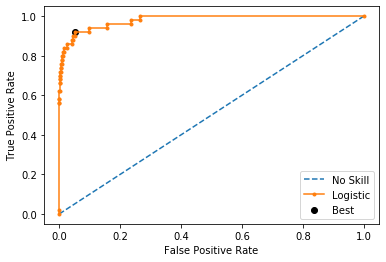

In [17]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix
from matplotlib import pyplot
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

print('fpr',fpr)
print('tpr',tpr)
print('thresholds', thresholds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
print('gmeans', gmeans)
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans

In [ ]:
np.round(0.51)

In [ ]:
a = torch.randn(10, 128, 25,2)
a_dim = torch.mean(a, 3).shape
a_dim

In [ ]:
m = [1,2,3,4,10]
np.mean(m)

In [ ]:
n = [1,2,3,4,5]

In [ ]:
sum(m)/(sum(m)+sum(n))

In [ ]:
np.mean(m)/(np.mean(m)+np.mean(n))

In [84]:
from padertorch.contrib.jensheit.eval_sad import get_tp_fp_tn_fn

In [89]:
y_true = np.concatenate([np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])])

y_pred = np.concatenate([np.array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])])
tp, fp, tn, fn = get_tp_fp_tn_fn(y_true, y_pred).ravel()
tp, fp, tn, fn

AttributeError: 'tuple' object has no attribute 'ravel'

## smooth vad

In [4]:
from padertorch.contrib.jensheit.eval_sad import smooth_vad
from sklearn import metrics

In [5]:
_true = np.random.randn(500)
_pred = np.random.randn(500)

In [9]:

vad_true = smooth_vad(_true, threshold=0.3, window=3, divisor=1)

vad_pred = smooth_vad(_pred, threshold=0.3, window=3, divisor=1)

tn, fp, fn, tp = metrics.confusion_matrix(vad_true, vad_pred).ravel()
tn, fp, fn, tp
fnr, fpr = (fn/(tp+fn)), (fp/(tn+fp))
dcf = 0.75*fnr + 0.25*fpr
print('dcf',dcf)


fpr_, tpr_, thresholds_ = metrics.roc_curve(vad_true, vad_pred)
#fnr_ = 1-tpr_
dcfs = 0.75*(1-tpr_) + 0.25*fpr_
print('thresholds_', thresholds_)
print('dcfs',dcfs)
print('min-dcfs', min(dcfs))
print('np.argmin(dcfs)',np.argmin(dcfs))

print(thresholds_[np.argmin(dcfs)])

dcf 0.3565135046113307
thresholds_ [2. 1. 0.]
dcfs [0.75      0.3565135 0.25     ]
min-dcfs 0.25
np.argmin(dcfs) 2
0.0
